<a href="https://colab.research.google.com/github/Roger-G/Data-augmentation/blob/master/Bert_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import package


In [0]:
!pip install transformers
!pip install pysnooper
import pandas as pd
import torch
from sklearn.metrics import multilabel_confusion_matrix
from torch import nn
from sklearn.metrics import precision_recall_fscore_support as score
import sys
from tqdm import trange
import numpy as np

import os
from collections import Counter
from IPython.display import clear_output
from torch.utils.data import Dataset
import seaborn as sns
from transformers import BertForSequenceClassification
from transformers import BertTokenizer
import torch
import pysnooper
# Load English tokenizer, tagger,  
# parser, NER and word vectors 
import re
from random import sample
from sklearn.utils import resample
import os.path as path
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

from torch.nn.utils.rnn import pad_sequence
import pandas as pd
from google.colab import drive
drive.mount('/content/drive')
absFilePath_aug = '/content/drive/My Drive/Data/Bert_ data augmentation-master/aug_data/rt-polaritydata/replacement/'
absFilePath = '/content/drive/My Drive/Data/Bert_ data augmentation-master/'
absFile_originaldata = '/content/drive/My Drive/Data/Bert_ data augmentation-master/datasets/rt-polaritydata/'
clear_output()

In [30]:
PRETRAINED_MODEL_NAME = "bert-base-uncased"  
tokenizer = BertTokenizer.from_pretrained(PRETRAINED_MODEL_NAME)
print("PyTorch version", torch.__version__)

PyTorch version 1.5.0+cu101


## Prepro_Data

In [0]:
class Prepro_Data(Dataset):
  
  def __init__(self, path, tokenizer, text_file_name, max_length=30):

    self.text, self.label = self.preprocess(text_file_name, max_length, path)    
    self.tokenizer = tokenizer
    self.path = path

  def __getitem__(self, idx):
    
    text, label = self.text[idx], self.label[idx]
    tokens = text.split()
    word_pieces = ['[CLS]'] + tokens   
    ids = self.tokenizer.convert_tokens_to_ids(tokens)
    label_tensor = torch.tensor(label)
    tokens_tensor = torch.tensor(ids)
    segments_tensor = torch.zeros_like(tokens_tensor)  # (1, seq_len)

    return (tokens_tensor, label_tensor)
  
  def  __len__(self):      
    return len(self.text)

  @staticmethod
  def load_data(path_, FILE_NAME):
    
    df_train = pd.read_csv(os.path.join(path_,'train.tsv'), sep='\t',  error_bad_lines=False)
    df_train = df_train.dropna()
    num_DA = max(df_train.label.value_counts()) - min(df_train.label.value_counts())

    if FILE_NAME != 'oversampling':
      df = pd.read_csv(os.path.join(path_, FILE_NAME + '.tsv'), sep='\t',  error_bad_lines=False)    
      df = df.dropna()

    else:
      # 选出差额， 补到原数据上面
      df_over_samp = resample(df_train[df_train.label==0], n_samples=num_DA, random_state=100, replace=True)
      df = pd.concat([df_over_samp, df_train])

    if FILE_NAME != 'train' and FILE_NAME != 'dev' and FILE_NAME != 'oversampling' and FILE_NAME != 'test':
      try:
        df_over_samp = resample(df, n_samples=num_DA, replace = False, random_state=10) 
        
      except ValueError:
        df_over_samp = resample(df, n_samples=num_DA, replace = True, random_state=10) 

      df = pd.concat([df_train, df_over_samp]) 

    else: 
      pass
    
    df = df.sample(frac = 1, replace=False, random_state=102)  

    return df

  @classmethod
  def preprocess(clf, FILE_NAME, max_length, path):
    data = clf.load_data(path, FILE_NAME)
    # print('all data', len(data))
    data = data[~(data.sentence.apply(lambda x : len(x.split()) > max_length))]
    # print('selected data', len(data))
    text, label = data.iloc[:, 0].values, data.iloc[:, 1].values

    return text, label

In [0]:
# data = pd.read_csv('/content/drive/My Drive/Data/Bert_ data augmentation-master/aug_data/twitter/train.tsv', sep='\t')
# length = []
# for x in data.sentence:
#   # print(x)
#   length.append(len(x.split()))
# print('mean', np.mean(length))
# length

In [0]:
def create_mini_batch(samples):

    tokens_tensors = [s[0] for s in samples]
    if samples[0][1] is not None:
        label_ids = torch.stack([s[1] for s in samples])
    else:
        label_ids = None
        
    tokens_tensors = pad_sequence(tokens_tensors, batch_first=True)
    masks_tensors = torch.zeros(tokens_tensors.shape,
                               dtype=torch.long)
    masks_tensors = masks_tensors.masked_fill(tokens_tensors != 0, 1)
    return tokens_tensors, masks_tensors, label_ids

## Model

In [34]:

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
def load_model():
  
  NUM_LABELS = 3
  model = BertForSequenceClassification.from_pretrained(PRETRAINED_MODEL_NAME,
                                                     num_labels=NUM_LABELS)
  model.to(device)
  return model

model = load_model()
# model.dropout = nn.Dropout(0.3)
print("""
name            module
----------------------""")
for name, module in model.named_children():
    if name == "bert":
        for n, _ in module.named_children():
            print(f"{name}:{n}")
    else:
        print("{:15} {}".format(name, module))


name            module
----------------------
bert:embeddings
bert:encoder
bert:pooler
dropout         Dropout(p=0.1, inplace=False)
classifier      Linear(in_features=768, out_features=3, bias=True)


## Utils

In [0]:
class utils():
  
  def __init__(self, EPOCHS):
    self.EPOCHS = EPOCHS

  def acc_loss(self, list_train_acc, list_val_acc, list_train_loss, list_val_loss):
    fig = plt.figure(figsize=(10, 5))
    
    
    ax1 = fig.add_subplot(1, 2, 1)
    sns.lineplot(ax=ax1, data=pd.DataFrame(list(zip(list_train_acc, list_val_acc)), columns=['training acc', 'validation acc'], index = range(1, len(list_val_acc)+1)))
    ax1.set(xlabel='Epochs', ylabel='Accuracy')
    ax1.locator_params(integer=True)

    ax2 = fig.add_subplot(1, 2, 2)
    sns.lineplot(ax=ax2, data=pd.DataFrame(list(zip(list_train_loss, list_val_loss)), columns=['training loss', 'validation loss'], index = range(1, len(list_val_loss)+1)))
    ax2.set(xlabel='Epochs', ylabel='Loss')
    ax2.locator_params(integer=True)
    plt.show()
  
  @staticmethod
  def draw_final(eval_dic, test_list_name):
    
    for eval_name, eval_list in eval_dic.items():
      sns.set(style="white", context="talk")
      plt.figure(figsize=(10,5)) 
      g = sns.barplot(x=np.array(eval_list), y=np.array(test_list_name), palette="deep")
      ax=g
    
      for p in ax.patches:
        ax.annotate("%.2f" % p.get_width(), (p.get_width(), p.get_y() + p.get_height() / 2.),
          fontsize=12, color='gray', xytext=(10, 0), textcoords='offset points')
    
      ax.axhline(0, color="k", clip_on=False)
      ax.set_xlabel(eval_name)
      # ax.set_ylabel("Methods")

  @staticmethod
  def path_setting(task_name = 'twitter', tech_name = 'Bert_ data augmentation-master'):
    abspath = '/content/drive/My Drive/Data/'
    model_path = path.join(abspath, tech_name + '/save_model')
    dataset_path = path.join(abspath, tech_name + '/datasets/{}/'.format(task_name))
    save_path = path.join(abspath, tech_name + '/aug_data/{}/'.format(task_name))
    return model_path, dataset_path, save_path

  @staticmethod
  def eval_matrix(list_array_value):
    fig = plt.figure(figsize=(12, 5))
  
    for i, array_value in enumerate(list_array_value):
      df = pd.DataFrame(array_value, columns=["0", "1", "2"], index=range(1,len(array_value)+1))
      ax = fig.add_subplot(1, 3, i+1)
      sns.lineplot(data=df, palette="tab10", ax=ax)
      ax.set(xlabel='Epochs', ylabel=['precision', 'recall', 'fscore'][i])

    plt.show()
  
  @staticmethod
  def draw_other_final(list_array_dic, test_list):

    for eval_name, list_array in list_array_dic.items():
      fig1 = plt.figure(figsize=(10, 5))
      barWidth = 0.07
      colors = ['#486093', '#BF7651', '#4F8F5B', '#A4484E', '#72659A', '#7A6553', '#C47FB2']
      # Set position of bar on X axis
      r1 = np.arange(len(list_array[0]))
      plt.bar(r1, list_array[0], color=colors[0], width=barWidth, edgecolor='white', label=test_list[0])
      for i in range(1, len(list_array)):
        r1 = [x + barWidth for x in r1] 
        plt.bar(r1, list_array[i], color=colors[i], width=barWidth, edgecolor='white', label=test_list[i])  
    
      # Add xticks on the middle of the group bars
      plt.xlabel('class', fontweight='bold')
      plt.xticks([r + barWidth for r in range(len(list_array[0]))], ['negative', 'neutral', 'positive'])
      plt.ylabel(eval_name)
      # Create legend & Show graphic
      plt.legend()
      plt.show()
    


## Training

In [0]:
class train_pre():

  def __init__(self, model, file_name, task_name, tech_name, epochs):
    self.model = model
    self.file_name = file_name
    self.task_name = task_name
    self.tech_name = tech_name
    self.epochs = epochs

  def get_predictions(self, dataset):
    predictions = None
    correct = 0
    total = 0
    loss_list = []

    with torch.no_grad():
      label_list = list()
      pred_list = list()

      for data in dataset:
        if next(self.model.parameters()).is_cuda:
          data = [t.to('cuda:0') for t in data if t is not None] 

        tokens_tensors, masks_tensors, labels = data
        loss, logits = self.model(input_ids=tokens_tensors,
                        attention_mask=masks_tensors,
                        labels = labels)
        
        _, pred = torch.max(logits.data, 1) 
        loss_list.append(loss.item())
        total += labels.size(0)
        correct += (pred == labels).sum().item()
        label_list.extend(labels.tolist())
        pred_list.extend(pred.tolist())

        if predictions is None:
          predictions = pred
        else:
          predictions = torch.cat((predictions, pred))
    # got all the evalution results for every class.
    self.precision, self.recall, self.fscore, _ = score(label_list, pred_list) # 每个 class 单独的参数
    # the second score function is to get average score of evaluation matrix.
    self.precision_avg, self.recall_avg, self.fscore_avg, _ = score(label_list, pred_list, average='macro' ) 
    acc = correct / total

    return acc, np.mean(loss_list)

  def training(self, optimizer, patient=3):
  
    self.model.train()
    best_acc = 0
    sum_acc = 0
    best_loss = float("inf")
    num_train_samples = len(self.train_loader)
    num_val_samples = len(self.dev_loader)
    draw_train_loss = []
    draw_train_acc = []
    draw_val_loss = []
    draw_val_acc = []
    model_sel = []
    count = 0

    for epoch in range(self.epochs):
      running_loss = 0.0
      val_loss = 0.0

      for data in self.train_loader:
        tokens_tensors, masks_tensors, labels = [t.to(device) for t in data]
        optimizer.zero_grad()
        outputs = self.model(input_ids=tokens_tensors,
                        attention_mask=masks_tensors,
                        labels=labels)
        
        loss = outputs[0]
        loss.backward()
        optimizer.step()
        # running_loss += loss.item()
        loss.detach()

      torch.cuda.empty_cache() 
      train_acc, train_loss = self.get_predictions(self.train_loader)
      
      # for data in self.dev_loader:
      #   tokens_tensors, masks_tensors, labels = [t.to(device) for t in data]
      #   outputs = self.model(input_ids=tokens_tensors,
      #                   attention_mask=masks_tensors,
      #                   labels=labels)
      #   loss = outputs[0]
      #   val_loss += loss.item()   

      val_acc, val_loss = self.get_predictions(self.dev_loader)

      if best_loss > val_loss:
        best_loss = val_loss
        best_acc = val_acc
        count = 0
        model_sel = []
      
      model_sel.append(self.model)
      print('[epoch %d] train_loss: %.3f, train_acc:%.3f, val_loss: %.3f, val_acc:%.3f' % 
            (epoch + 1, train_loss, train_acc, val_loss, val_acc))
      
      count += 1
      
      if count > patient:
        torch.save(self.model_path, '{}.pt'.format(self.file_name))
        break

      draw_train_loss.append(train_loss)
      draw_train_acc.append(train_acc)
      draw_val_loss.append(val_loss)
      draw_val_acc.append(val_acc)

    # torch.save({'state_dict': self.model.state_dict()}, path.join(self.model_path,'{}.pt'.format(self.file_name)))
    draw = utils(len(draw_train_acc))
    draw.acc_loss(draw_train_acc, draw_val_acc, draw_train_loss, draw_val_loss)

    ''' when testing, do not comment them'''
    # self.model = model_sel[0]
    test_acc, test_loss = self.get_predictions(self.test_loader)
    
    return test_acc, test_loss

  def setting(self):

    self.model_path, dataset_path, save_path = utils.path_setting(self.task_name, self.tech_name)

    if self.tech_name == 'Bert_ data augmentation-master' and self.task_name == 'toxic':
      path_ = os.path.join(save_path, 'replacement')
    else:
      path_ = save_path

    optimizer = torch.optim.Adam(self.model.parameters(), lr= 2e-6)
    BATCH_SIZE = 64
    trainset = Prepro_Data(path=path_, tokenizer=tokenizer, text_file_name=self.file_name)
    self.train_loader = DataLoader(trainset, batch_size=BATCH_SIZE, collate_fn=create_mini_batch)

    train_acc, _ = self.get_predictions(self.train_loader)
    print('\n', 'before training model, the accuracy is {}'.format(train_acc))
    devset = Prepro_Data(path=path_, tokenizer=tokenizer, text_file_name='dev') # 对 dev data preprocess
    testset = Prepro_Data(path=path_, tokenizer=tokenizer, text_file_name='test') # 对 dev data preprocess
    
    self.dev_loader = DataLoader(devset, BATCH_SIZE, collate_fn=create_mini_batch)
    self.test_loader = DataLoader(testset, BATCH_SIZE, collate_fn=create_mini_batch)
    acc, loss = self.training(optimizer, patient=3)
    # _, acc = get_predictions(trained_model, testloader, compute_acc=True)
    print('After training model_{}, the accuracy is {}'.format(self.file_name, acc))

    return acc, loss, self.precision_avg, self.recall_avg, self.fscore_avg, self.precision, self.recall, self.fscore



## Run

In [0]:

def execute(test_list, tech_name, task_name):
  
  acc_list = []
  epochs = 20
  loss_list = []
  precision_list = []
  recall_list = []
  fscore_list = []
  list_prec = []
  list_recall = []
  list_fs = []
  for i, file_name in enumerate(test_list):
    print('-' * 70)
    print('Start to train model use the data : {}'.format(file_name))
    print('-' * 70)
    model = load_model()
    train = train_pre(model, file_name, task_name, tech_name, epochs=epochs)
    acc, loss, precision_avg, recall_avg, fscore_avg, precision, recall, fscore = train.setting()
    
    precision_list.append(precision)
    recall_list.append(recall)
    fscore_list.append(fscore)

    acc_list.append(acc)
    loss_list.append(loss)
    list_prec.append(precision_avg)
    list_recall.append(recall_avg)
    list_fs.append(fscore_avg)
  
  print('acc_list', acc_list)
  print('loss_list', loss_list)
  print('precision_list', precision_list)
  print('recall_list', recall_list)
  print('fscore_list', fscore_list)
  print('average prec', list_prec)
  print('average recall', list_recall)
  print('average fs', list_fs)

  utils.draw_final({'loss': loss_list, 'accuracy': acc_list, 
                    'average fscore': list_fs, 'average precision': list_prec,
                    'average recall': list_recall}, test_list)

  utils.draw_other_final( {'precision': precision_list, 
                    'recall': recall_list, 'fscore': fscore_list}, test_list)



### EDA

----------------------------------------------------------------------
Start to train model use the data : train
----------------------------------------------------------------------

 before training model, the accuracy is 0.3914018901259149
[epoch 1] train_loss: 0.820, train_acc:0.615, val_loss: 0.831, val_acc:0.604
[epoch 2] train_loss: 0.743, train_acc:0.657, val_loss: 0.764, val_acc:0.637
[epoch 3] train_loss: 0.708, train_acc:0.676, val_loss: 0.747, val_acc:0.655
[epoch 4] train_loss: 0.686, train_acc:0.691, val_loss: 0.737, val_acc:0.660
[epoch 5] train_loss: 0.666, train_acc:0.700, val_loss: 0.730, val_acc:0.665
[epoch 6] train_loss: 0.644, train_acc:0.714, val_loss: 0.725, val_acc:0.663
[epoch 7] train_loss: 0.627, train_acc:0.721, val_loss: 0.723, val_acc:0.669
[epoch 8] train_loss: 0.610, train_acc:0.732, val_loss: 0.726, val_acc:0.675
[epoch 9] train_loss: 0.590, train_acc:0.743, val_loss: 0.730, val_acc:0.668
[epoch 10] train_loss: 0.572, train_acc:0.754, val_loss: 0.728,

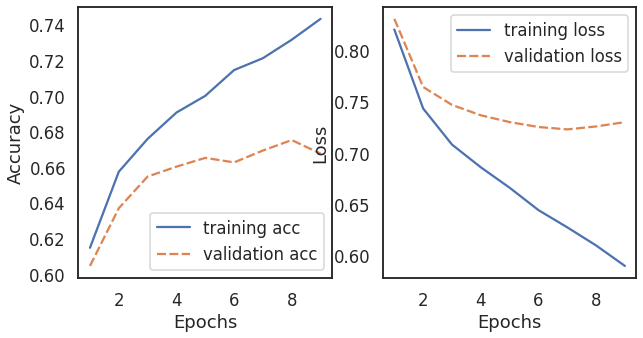

After training model_train, the accuracy is 0.6607649682389513
----------------------------------------------------------------------
Start to train model use the data : oversampling
----------------------------------------------------------------------

 before training model, the accuracy is 0.30781896570401024
[epoch 1] train_loss: 0.803, train_acc:0.642, val_loss: 0.865, val_acc:0.585
[epoch 2] train_loss: 0.727, train_acc:0.681, val_loss: 0.799, val_acc:0.626
[epoch 3] train_loss: 0.680, train_acc:0.704, val_loss: 0.789, val_acc:0.631
[epoch 4] train_loss: 0.642, train_acc:0.724, val_loss: 0.781, val_acc:0.639
[epoch 5] train_loss: 0.608, train_acc:0.741, val_loss: 0.780, val_acc:0.638
[epoch 6] train_loss: 0.578, train_acc:0.757, val_loss: 0.786, val_acc:0.645
[epoch 7] train_loss: 0.547, train_acc:0.772, val_loss: 0.774, val_acc:0.649
[epoch 8] train_loss: 0.523, train_acc:0.782, val_loss: 0.798, val_acc:0.653
[epoch 9] train_loss: 0.494, train_acc:0.797, val_loss: 0.786, val_ac

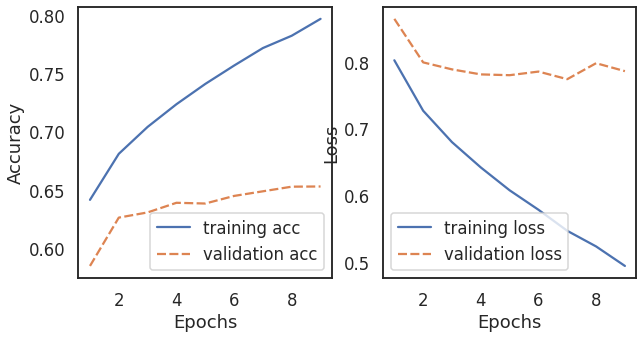

After training model_oversampling, the accuracy is 0.6461684011352885
----------------------------------------------------------------------
Start to train model use the data : 2_del
----------------------------------------------------------------------

 before training model, the accuracy is 0.34948703519328167
[epoch 1] train_loss: 0.786, train_acc:0.648, val_loss: 0.859, val_acc:0.587
[epoch 2] train_loss: 0.716, train_acc:0.686, val_loss: 0.814, val_acc:0.617
[epoch 3] train_loss: 0.675, train_acc:0.707, val_loss: 0.805, val_acc:0.626
[epoch 4] train_loss: 0.641, train_acc:0.722, val_loss: 0.789, val_acc:0.626
[epoch 5] train_loss: 0.608, train_acc:0.737, val_loss: 0.794, val_acc:0.633
[epoch 6] train_loss: 0.577, train_acc:0.754, val_loss: 0.787, val_acc:0.643
[epoch 7] train_loss: 0.550, train_acc:0.766, val_loss: 0.788, val_acc:0.644
[epoch 8] train_loss: 0.523, train_acc:0.780, val_loss: 0.789, val_acc:0.656
[epoch 9] train_loss: 0.499, train_acc:0.791, val_loss: 0.802, val_ac

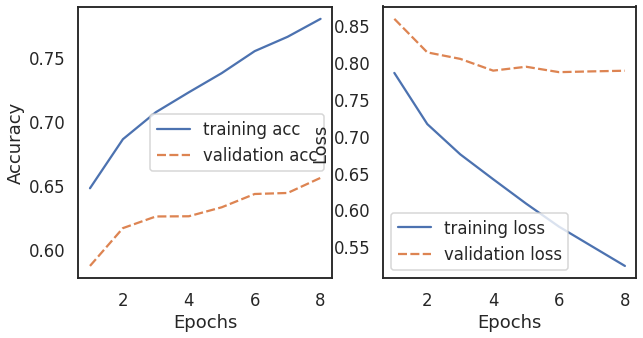

After training model_2_del, the accuracy is 0.6404919583727531
----------------------------------------------------------------------
Start to train model use the data : 3_del
----------------------------------------------------------------------

 before training model, the accuracy is 0.339025974025974
[epoch 1] train_loss: 0.775, train_acc:0.651, val_loss: 0.864, val_acc:0.590
[epoch 2] train_loss: 0.694, train_acc:0.695, val_loss: 0.809, val_acc:0.615
[epoch 3] train_loss: 0.651, train_acc:0.713, val_loss: 0.796, val_acc:0.630
[epoch 4] train_loss: 0.617, train_acc:0.730, val_loss: 0.772, val_acc:0.643
[epoch 5] train_loss: 0.586, train_acc:0.746, val_loss: 0.788, val_acc:0.639
[epoch 6] train_loss: 0.559, train_acc:0.760, val_loss: 0.772, val_acc:0.649
[epoch 7] train_loss: 0.532, train_acc:0.771, val_loss: 0.792, val_acc:0.646
[epoch 8] train_loss: 0.511, train_acc:0.783, val_loss: 0.789, val_acc:0.654
[epoch 9] train_loss: 0.488, train_acc:0.793, val_loss: 0.802, val_acc:0.649


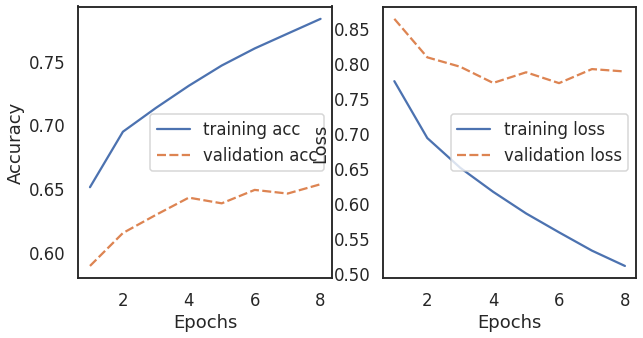

After training model_3_del, the accuracy is 0.6471144749290445
----------------------------------------------------------------------
Start to train model use the data : 4_del
----------------------------------------------------------------------

 before training model, the accuracy is 0.3448537049861496
[epoch 1] train_loss: 0.751, train_acc:0.663, val_loss: 0.848, val_acc:0.595
[epoch 2] train_loss: 0.673, train_acc:0.703, val_loss: 0.798, val_acc:0.629
[epoch 3] train_loss: 0.634, train_acc:0.719, val_loss: 0.780, val_acc:0.638
[epoch 4] train_loss: 0.604, train_acc:0.735, val_loss: 0.762, val_acc:0.653
[epoch 5] train_loss: 0.577, train_acc:0.749, val_loss: 0.771, val_acc:0.647
[epoch 6] train_loss: 0.556, train_acc:0.758, val_loss: 0.762, val_acc:0.657
[epoch 7] train_loss: 0.529, train_acc:0.770, val_loss: 0.761, val_acc:0.661
[epoch 8] train_loss: 0.510, train_acc:0.782, val_loss: 0.764, val_acc:0.660
[epoch 9] train_loss: 0.487, train_acc:0.792, val_loss: 0.781, val_acc:0.654


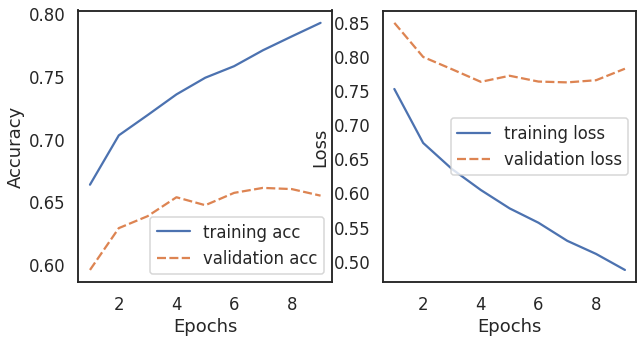

After training model_4_del, the accuracy is 0.652655764292472
----------------------------------------------------------------------
Start to train model use the data : 5_del
----------------------------------------------------------------------

 before training model, the accuracy is 0.3046875
[epoch 1] train_loss: 0.733, train_acc:0.671, val_loss: 0.841, val_acc:0.607
[epoch 2] train_loss: 0.659, train_acc:0.705, val_loss: 0.789, val_acc:0.637
[epoch 3] train_loss: 0.617, train_acc:0.727, val_loss: 0.781, val_acc:0.635
[epoch 4] train_loss: 0.588, train_acc:0.741, val_loss: 0.770, val_acc:0.650
[epoch 5] train_loss: 0.567, train_acc:0.750, val_loss: 0.756, val_acc:0.657
[epoch 6] train_loss: 0.541, train_acc:0.764, val_loss: 0.756, val_acc:0.657
[epoch 7] train_loss: 0.524, train_acc:0.772, val_loss: 0.757, val_acc:0.662
[epoch 8] train_loss: 0.498, train_acc:0.785, val_loss: 0.762, val_acc:0.666


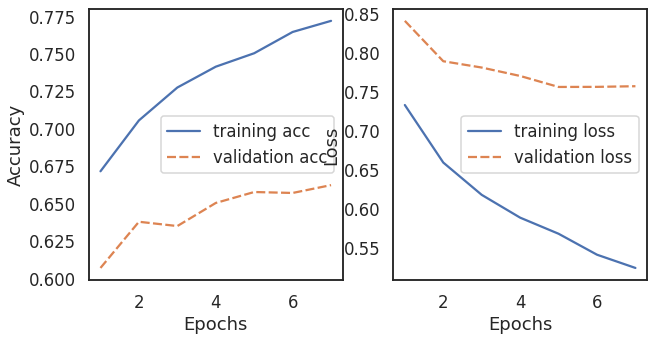

After training model_5_del, the accuracy is 0.6508987701040682
acc_list [0.6607649682389513, 0.6461684011352885, 0.6404919583727531, 0.6471144749290445, 0.652655764292472, 0.6508987701040682]
loss_list [0.7368555888533592, 0.8129926377843166, 0.8193614924776143, 0.8065052006779045, 0.8011934012174606, 0.7713417081997312]
precision_list [array([0.58955224, 0.63452055, 0.72506537]), array([0.50031827, 0.64490783, 0.73878523]), array([0.48228346, 0.6382852 , 0.73926868]), array([0.49784483, 0.64504505, 0.72730669]), array([0.51799163, 0.63472222, 0.73924731]), array([0.52756573, 0.63160839, 0.73194707])]
recall_list [array([0.54109589, 0.70181818, 0.66223132]), array([0.67294521, 0.64666667, 0.63493688]), array([0.62928082, 0.64969697, 0.6345957 ]), array([0.59332192, 0.65090909, 0.6642784 ]), array([0.52996575, 0.69242424, 0.65677243]), array([0.53253425, 0.68424242, 0.66052542])]
fscore_list [array([0.56428571, 0.66647482, 0.69222539]), array([0.57393209, 0.64578605, 0.68293578]), array

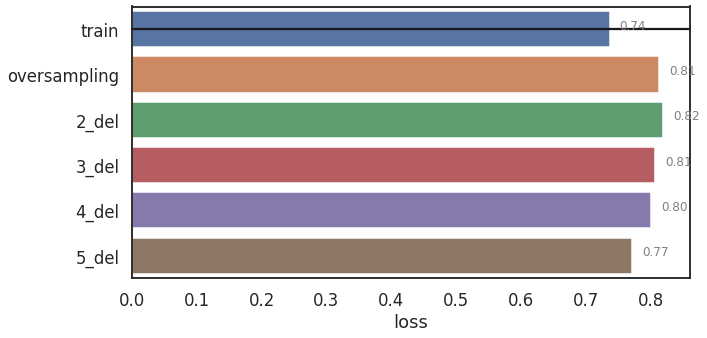

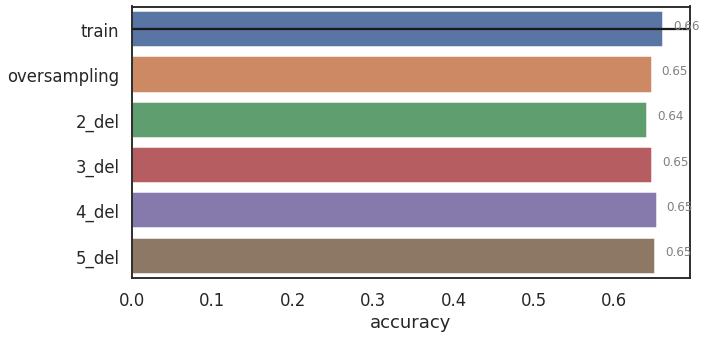

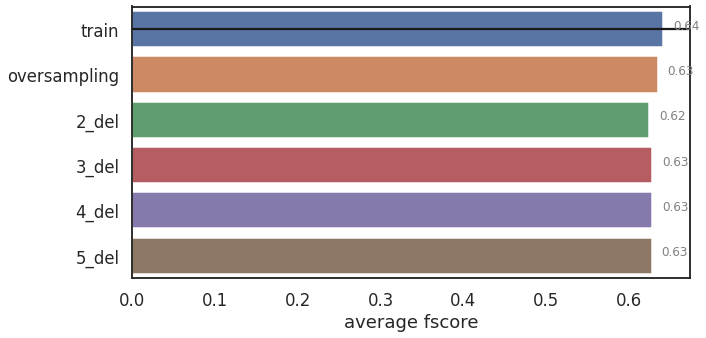

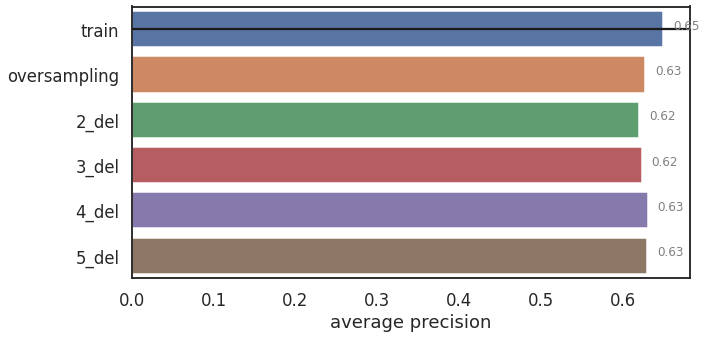

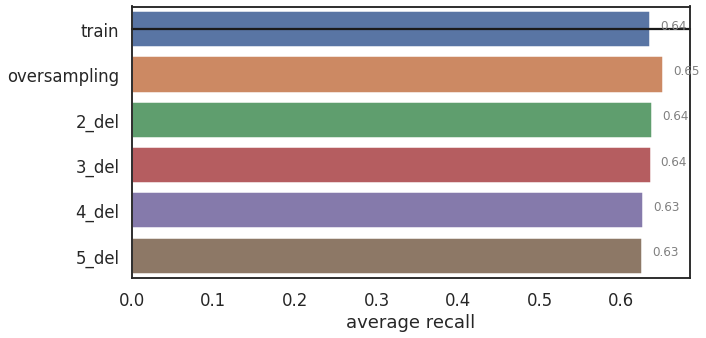

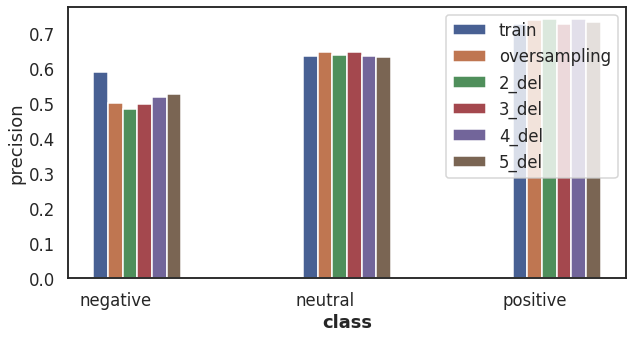

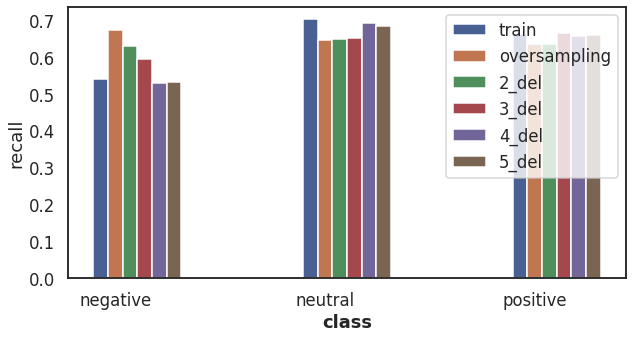

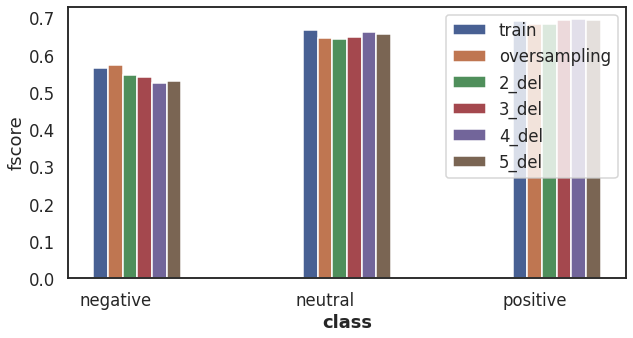

CPU times: user 2h 12min 44s, sys: 42min 28s, total: 2h 55min 13s
Wall time: 2h 55min 18s


In [42]:
%%time
test_list = [
              'train',
              'oversampling',
             '2_del',
             '3_del',
             '4_del',
             '5_del',

              ]
              
task_name = 'twitter'
tech_name = 'EDA'

execute(test_list, tech_name, task_name)

### Fasttext aug

----------------------------------------------------------------------
Start to train model use the data : train
----------------------------------------------------------------------

 before training model, the accuracy is 0.45043327070304834
[epoch 1] train_loss: 0.829, train_acc:0.605, val_loss: 0.841, val_acc:0.596
[epoch 2] train_loss: 0.739, train_acc:0.660, val_loss: 0.764, val_acc:0.645
[epoch 3] train_loss: 0.709, train_acc:0.678, val_loss: 0.743, val_acc:0.656
[epoch 4] train_loss: 0.682, train_acc:0.692, val_loss: 0.732, val_acc:0.668
[epoch 5] train_loss: 0.662, train_acc:0.701, val_loss: 0.731, val_acc:0.665
[epoch 6] train_loss: 0.643, train_acc:0.715, val_loss: 0.728, val_acc:0.667
[epoch 7] train_loss: 0.624, train_acc:0.723, val_loss: 0.724, val_acc:0.675
[epoch 8] train_loss: 0.604, train_acc:0.735, val_loss: 0.728, val_acc:0.674
[epoch 9] train_loss: 0.587, train_acc:0.743, val_loss: 0.733, val_acc:0.665
[epoch 10] train_loss: 0.572, train_acc:0.753, val_loss: 0.733

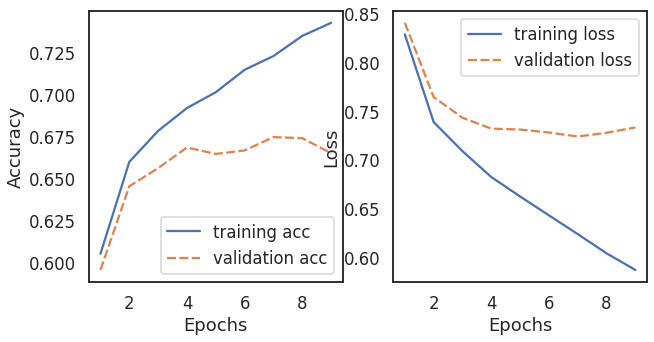

After training model_train, the accuracy is 0.6687390187863225
----------------------------------------------------------------------
Start to train model use the data : oversampling
----------------------------------------------------------------------

 before training model, the accuracy is 0.3047208440756548
[epoch 1] train_loss: 0.808, train_acc:0.637, val_loss: 0.861, val_acc:0.588
[epoch 2] train_loss: 0.723, train_acc:0.684, val_loss: 0.796, val_acc:0.625
[epoch 3] train_loss: 0.677, train_acc:0.707, val_loss: 0.785, val_acc:0.632
[epoch 4] train_loss: 0.641, train_acc:0.724, val_loss: 0.776, val_acc:0.635
[epoch 5] train_loss: 0.610, train_acc:0.739, val_loss: 0.766, val_acc:0.650
[epoch 6] train_loss: 0.579, train_acc:0.755, val_loss: 0.762, val_acc:0.658
[epoch 7] train_loss: 0.545, train_acc:0.773, val_loss: 0.776, val_acc:0.657
[epoch 8] train_loss: 0.516, train_acc:0.785, val_loss: 0.775, val_acc:0.656
[epoch 9] train_loss: 0.495, train_acc:0.796, val_loss: 0.790, val_acc

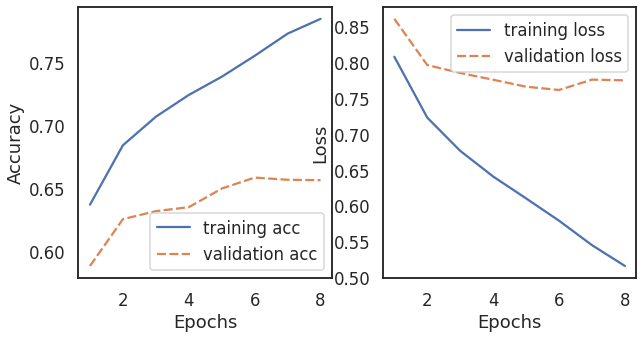

After training model_oversampling, the accuracy is 0.6546830652790918
----------------------------------------------------------------------
Start to train model use the data : 2_rep
----------------------------------------------------------------------

 before training model, the accuracy is 0.3048973486244499
[epoch 1] train_loss: 0.756, train_acc:0.663, val_loss: 0.846, val_acc:0.601
[epoch 2] train_loss: 0.682, train_acc:0.701, val_loss: 0.800, val_acc:0.625
[epoch 3] train_loss: 0.645, train_acc:0.718, val_loss: 0.775, val_acc:0.638
[epoch 4] train_loss: 0.609, train_acc:0.736, val_loss: 0.775, val_acc:0.637
[epoch 5] train_loss: 0.582, train_acc:0.749, val_loss: 0.766, val_acc:0.649
[epoch 6] train_loss: 0.556, train_acc:0.764, val_loss: 0.764, val_acc:0.652
[epoch 7] train_loss: 0.530, train_acc:0.774, val_loss: 0.768, val_acc:0.660
[epoch 8] train_loss: 0.513, train_acc:0.784, val_loss: 0.768, val_acc:0.658
[epoch 9] train_loss: 0.490, train_acc:0.795, val_loss: 0.786, val_acc

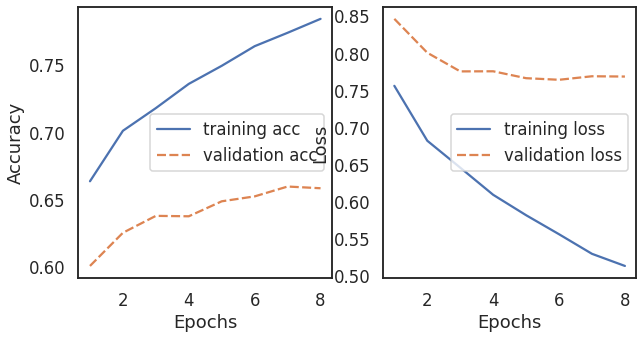

After training model_2_rep, the accuracy is 0.6534666846871199
----------------------------------------------------------------------
Start to train model use the data : 3_rep
----------------------------------------------------------------------

 before training model, the accuracy is 0.33237194778158474
[epoch 1] train_loss: 0.759, train_acc:0.659, val_loss: 0.859, val_acc:0.592
[epoch 2] train_loss: 0.677, train_acc:0.700, val_loss: 0.811, val_acc:0.623
[epoch 3] train_loss: 0.636, train_acc:0.721, val_loss: 0.780, val_acc:0.634
[epoch 4] train_loss: 0.603, train_acc:0.739, val_loss: 0.773, val_acc:0.639
[epoch 5] train_loss: 0.575, train_acc:0.750, val_loss: 0.776, val_acc:0.646
[epoch 6] train_loss: 0.551, train_acc:0.762, val_loss: 0.765, val_acc:0.647
[epoch 7] train_loss: 0.529, train_acc:0.772, val_loss: 0.777, val_acc:0.647
[epoch 8] train_loss: 0.512, train_acc:0.779, val_loss: 0.770, val_acc:0.657
[epoch 9] train_loss: 0.489, train_acc:0.791, val_loss: 0.779, val_acc:0.652

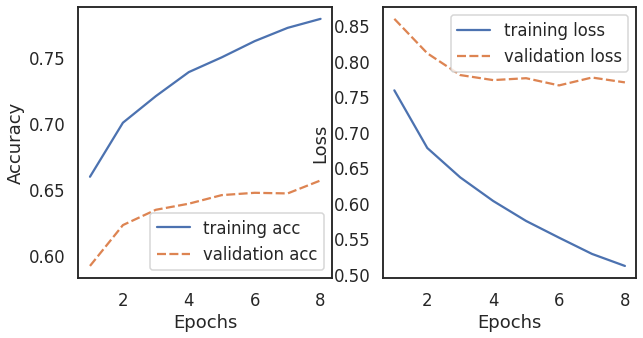

After training model_3_rep, the accuracy is 0.6568455196648195
----------------------------------------------------------------------
Start to train model use the data : 4_rep
----------------------------------------------------------------------

 before training model, the accuracy is 0.3086765120464945
[epoch 1] train_loss: 0.752, train_acc:0.661, val_loss: 0.856, val_acc:0.593
[epoch 2] train_loss: 0.667, train_acc:0.706, val_loss: 0.809, val_acc:0.627
[epoch 3] train_loss: 0.628, train_acc:0.724, val_loss: 0.790, val_acc:0.634
[epoch 4] train_loss: 0.600, train_acc:0.738, val_loss: 0.770, val_acc:0.640
[epoch 5] train_loss: 0.571, train_acc:0.752, val_loss: 0.770, val_acc:0.647
[epoch 6] train_loss: 0.547, train_acc:0.762, val_loss: 0.763, val_acc:0.648
[epoch 7] train_loss: 0.523, train_acc:0.775, val_loss: 0.775, val_acc:0.652
[epoch 8] train_loss: 0.503, train_acc:0.786, val_loss: 0.770, val_acc:0.660
[epoch 9] train_loss: 0.482, train_acc:0.794, val_loss: 0.779, val_acc:0.648


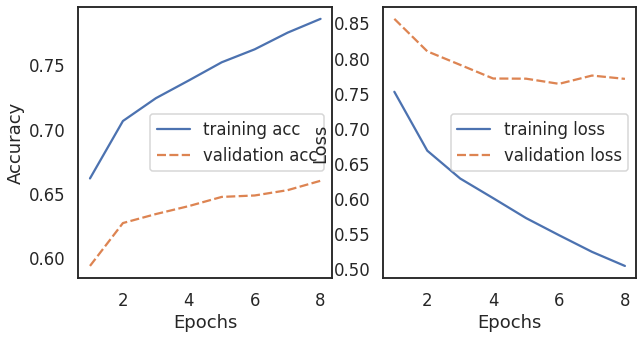

After training model_4_rep, the accuracy is 0.6537369914853358
----------------------------------------------------------------------
Start to train model use the data : 5_rep
----------------------------------------------------------------------

 before training model, the accuracy is 0.3399865489336776
[epoch 1] train_loss: 0.745, train_acc:0.666, val_loss: 0.854, val_acc:0.591
[epoch 2] train_loss: 0.666, train_acc:0.705, val_loss: 0.812, val_acc:0.617
[epoch 3] train_loss: 0.623, train_acc:0.727, val_loss: 0.792, val_acc:0.634
[epoch 4] train_loss: 0.591, train_acc:0.743, val_loss: 0.780, val_acc:0.640
[epoch 5] train_loss: 0.570, train_acc:0.751, val_loss: 0.763, val_acc:0.647
[epoch 6] train_loss: 0.541, train_acc:0.765, val_loss: 0.784, val_acc:0.645
[epoch 7] train_loss: 0.516, train_acc:0.777, val_loss: 0.767, val_acc:0.654
[epoch 8] train_loss: 0.500, train_acc:0.784, val_loss: 0.768, val_acc:0.658


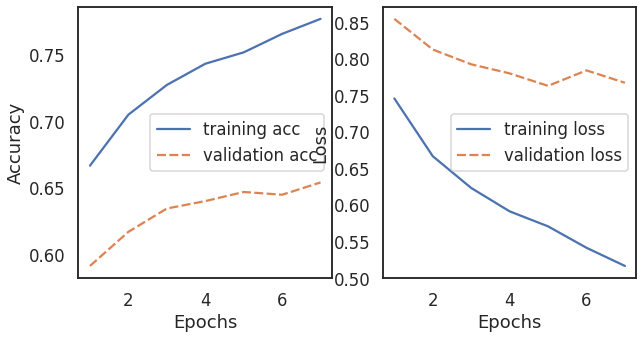

After training model_5_rep, the accuracy is 0.6541424516826598
acc_list [0.6687390187863225, 0.6546830652790918, 0.6534666846871199, 0.6568455196648195, 0.6537369914853358, 0.6541424516826598]
loss_list [0.7400103830571833, 0.7960572885028248, 0.783965563465809, 0.7852141163472471, 0.7797889606706028, 0.771750852208713]
precision_list [array([0.63193658, 0.63301072, 0.73152618]), array([0.52150538, 0.64833872, 0.74223108]), array([0.53672788, 0.6336195 , 0.73513514]), array([0.55388693, 0.63155037, 0.7380031 ]), array([0.53727506, 0.63682008, 0.72799396]), array([0.56363636, 0.63033433, 0.72224299])]
recall_list [array([0.47773973, 0.73333333, 0.67212555]), array([0.66438356, 0.66818182, 0.63561924]), array([0.5505137 , 0.69333333, 0.64960764]), array([0.53681507, 0.70484848, 0.65063118]), array([0.53681507, 0.69181818, 0.65745479]), array([0.50428082, 0.70272727, 0.6591607 ])]
fscore_list [array([0.54412482, 0.67948898, 0.70056899]), array([0.58433735, 0.65811073, 0.68480059]), array(

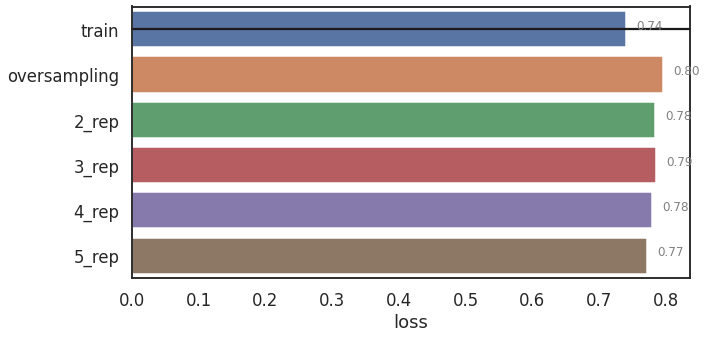

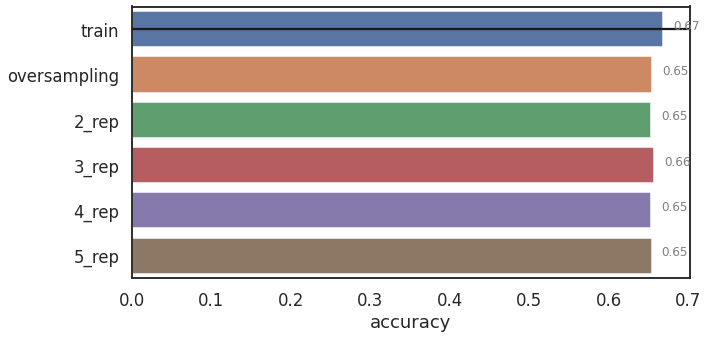

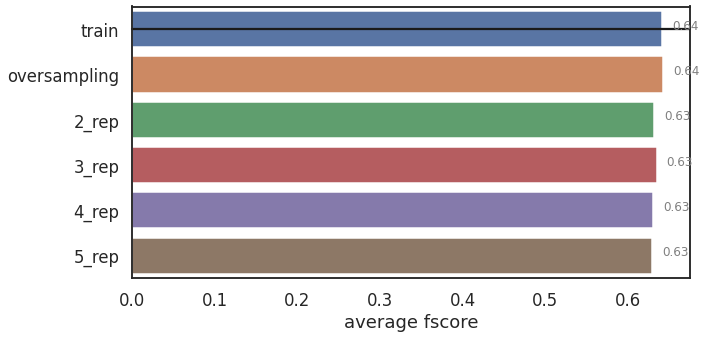

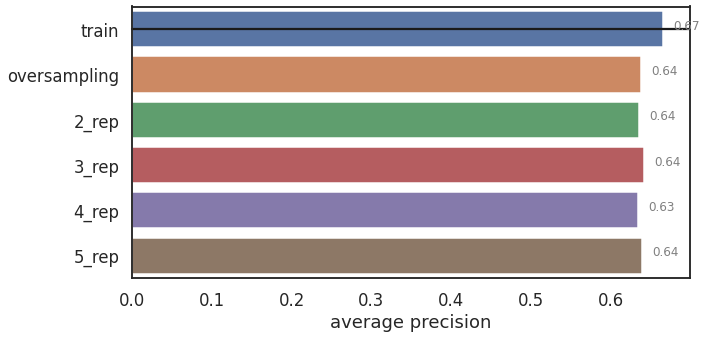

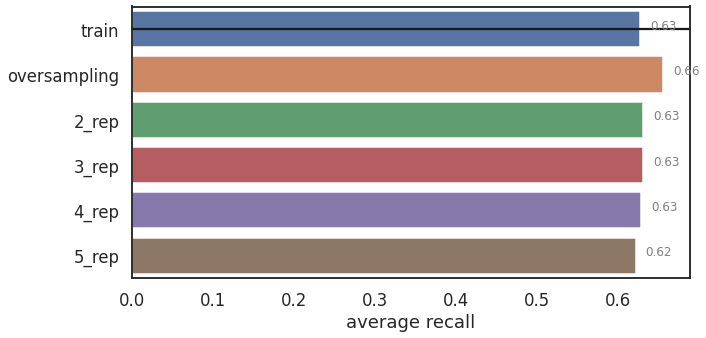

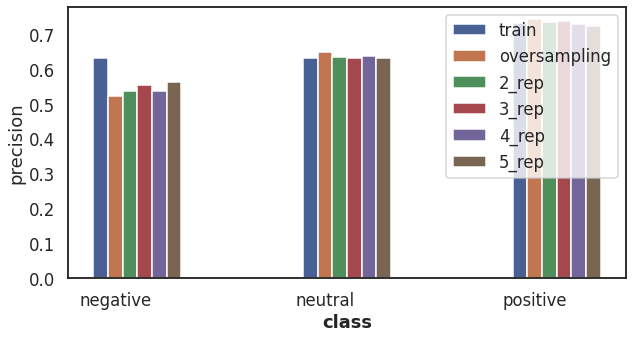

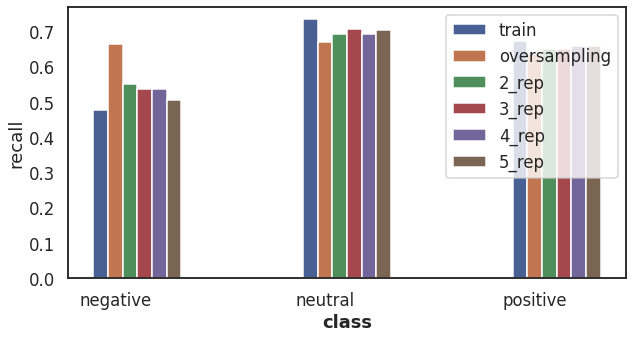

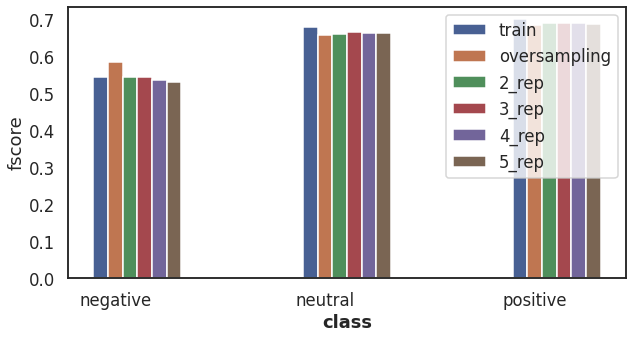

CPU times: user 2h 9min 5s, sys: 41min 30s, total: 2h 50min 35s
Wall time: 2h 50min 41s


In [40]:
%%time
test_list = [
              'train',
              'oversampling',
             '2_rep',
             '3_rep',
             '4_rep',
             '5_rep',
              ]
              
task_name = 'twitter'
tech_name = 'Fasttext_augmentation'

execute(test_list, tech_name, task_name)

### Back translation

----------------------------------------------------------------------
Start to train model use the data : train
----------------------------------------------------------------------

 before training model, the accuracy is 0.443646765192518
[epoch 1] train_loss: 0.806, train_acc:0.623, val_loss: 0.813, val_acc:0.618
[epoch 2] train_loss: 0.736, train_acc:0.661, val_loss: 0.759, val_acc:0.647
[epoch 3] train_loss: 0.702, train_acc:0.679, val_loss: 0.741, val_acc:0.657
[epoch 4] train_loss: 0.681, train_acc:0.691, val_loss: 0.735, val_acc:0.656
[epoch 5] train_loss: 0.660, train_acc:0.703, val_loss: 0.725, val_acc:0.668
[epoch 6] train_loss: 0.638, train_acc:0.716, val_loss: 0.721, val_acc:0.671
[epoch 7] train_loss: 0.622, train_acc:0.724, val_loss: 0.725, val_acc:0.670
[epoch 8] train_loss: 0.603, train_acc:0.735, val_loss: 0.726, val_acc:0.671
[epoch 9] train_loss: 0.584, train_acc:0.744, val_loss: 0.728, val_acc:0.673


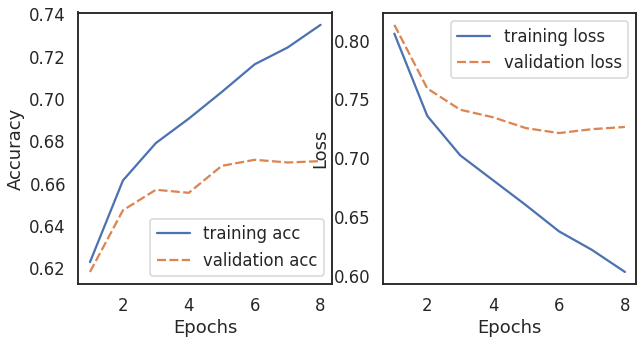

After training model_train, the accuracy is 0.6561697526692797
----------------------------------------------------------------------
Start to train model use the data : oversampling
----------------------------------------------------------------------

 before training model, the accuracy is 0.34421647854063303
[epoch 1] train_loss: 0.798, train_acc:0.644, val_loss: 0.857, val_acc:0.593
[epoch 2] train_loss: 0.716, train_acc:0.688, val_loss: 0.790, val_acc:0.632
[epoch 3] train_loss: 0.675, train_acc:0.706, val_loss: 0.787, val_acc:0.630
[epoch 4] train_loss: 0.636, train_acc:0.729, val_loss: 0.774, val_acc:0.645
[epoch 5] train_loss: 0.604, train_acc:0.743, val_loss: 0.771, val_acc:0.649
[epoch 6] train_loss: 0.571, train_acc:0.760, val_loss: 0.777, val_acc:0.648
[epoch 7] train_loss: 0.543, train_acc:0.774, val_loss: 0.775, val_acc:0.660
[epoch 8] train_loss: 0.517, train_acc:0.784, val_loss: 0.785, val_acc:0.656


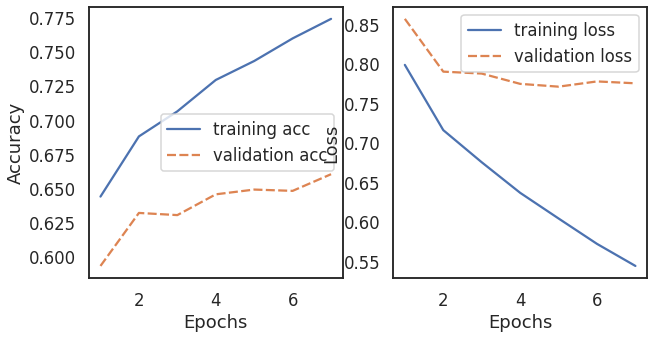

After training model_oversampling, the accuracy is 0.6473847817272604
----------------------------------------------------------------------
Start to train model use the data : negative_aug
----------------------------------------------------------------------

 before training model, the accuracy is 0.30507886982145954
[epoch 1] train_loss: 0.776, train_acc:0.654, val_loss: 0.854, val_acc:0.591
[epoch 2] train_loss: 0.696, train_acc:0.691, val_loss: 0.791, val_acc:0.627
[epoch 3] train_loss: 0.655, train_acc:0.712, val_loss: 0.764, val_acc:0.646
[epoch 4] train_loss: 0.627, train_acc:0.725, val_loss: 0.760, val_acc:0.653
[epoch 5] train_loss: 0.599, train_acc:0.741, val_loss: 0.750, val_acc:0.662
[epoch 6] train_loss: 0.570, train_acc:0.754, val_loss: 0.761, val_acc:0.651
[epoch 7] train_loss: 0.550, train_acc:0.764, val_loss: 0.752, val_acc:0.662
[epoch 8] train_loss: 0.526, train_acc:0.774, val_loss: 0.760, val_acc:0.662


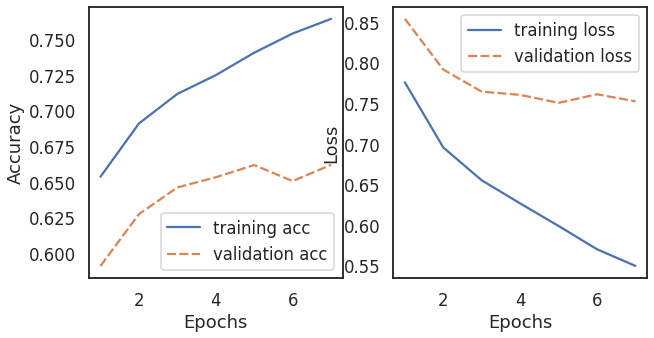

After training model_negative_aug, the accuracy is 0.652385457494256
acc_list [0.6561697526692797, 0.6473847817272604, 0.652385457494256]
loss_list [0.7475093305110931, 0.791467487298209, 0.7687827919063897]
precision_list [array([0.62022472, 0.62195767, 0.71528032]), array([0.4921235 , 0.65018428, 0.74021909]), array([0.51176471, 0.63869863, 0.74674556])]
recall_list [array([0.47260274, 0.71242424, 0.66598431]), array([0.66866438, 0.64151515, 0.64551348]), array([0.59589041, 0.67818182, 0.64585466])]
fscore_list [array([0.53644315, 0.66412429, 0.68975265]), array([0.56696915, 0.64582062, 0.68963003]), array([0.55063291, 0.65784832, 0.69264544])]
average prec [0.6524875711737453, 0.6275089569939006, 0.6324029660498389]
average recall [0.6170037626159947, 0.651897670568644, 0.6399756287514452]
average fs [0.6301066975500119, 0.6341399346544784, 0.6337088934912689]


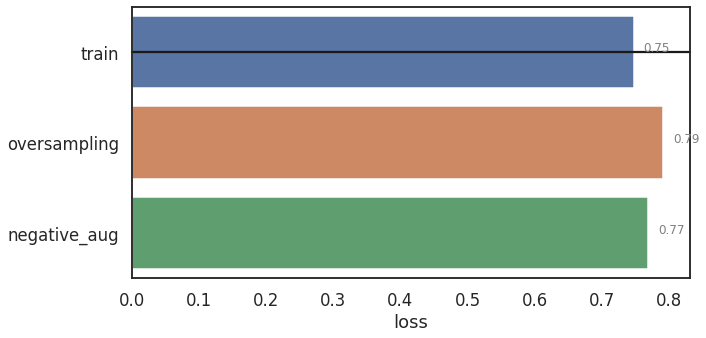

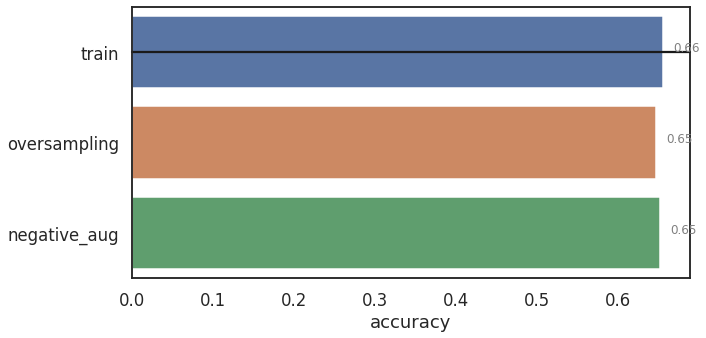

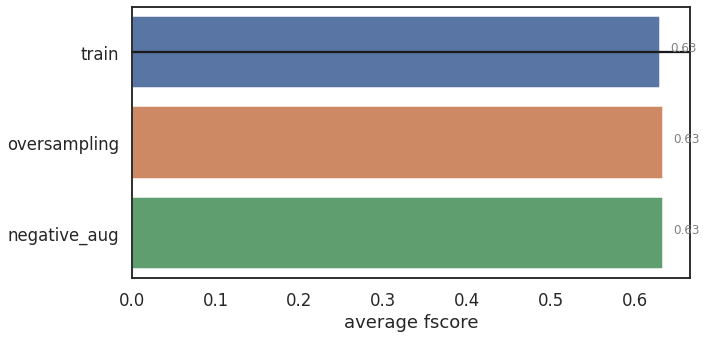

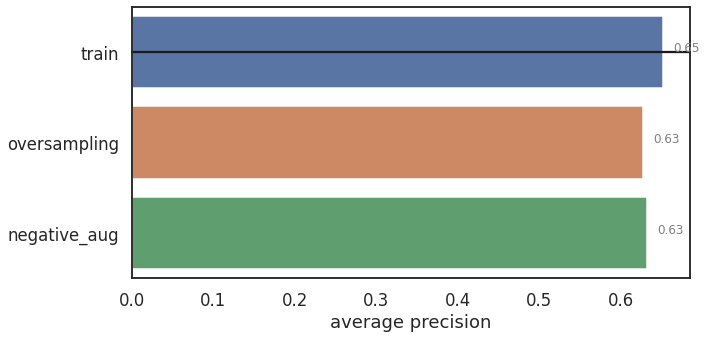

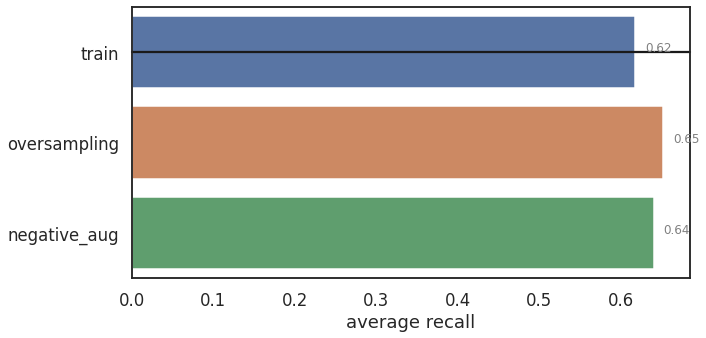

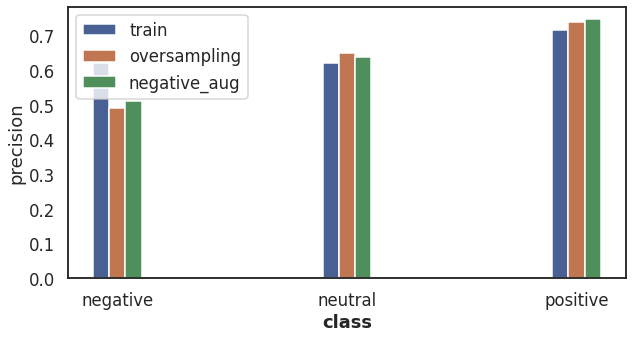

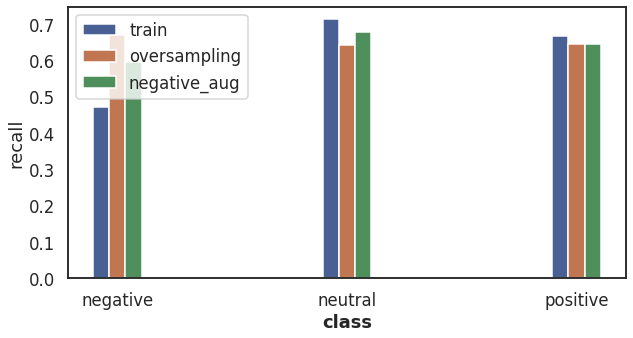

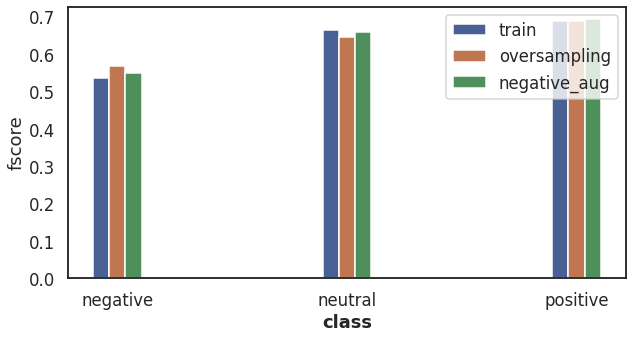

CPU times: user 57min 18s, sys: 18min 23s, total: 1h 15min 42s
Wall time: 1h 15min 46s


In [41]:
%%time
test_list = [
              'train',
              'oversampling',
             'negative_aug'
              ]
              
task_name = 'twitter'
tech_name = 'Back_trans'

execute(test_list, tech_name, task_name)

### BERT

----------------------------------------------------------------------
Start to train model use the data : train
----------------------------------------------------------------------

 before training model, the accuracy is 0.4304944053394655
[epoch 1] train_loss: 0.841, train_acc:0.595, val_loss: 0.854, val_acc:0.582
[epoch 2] train_loss: 0.749, train_acc:0.657, val_loss: 0.780, val_acc:0.633
[epoch 3] train_loss: 0.715, train_acc:0.676, val_loss: 0.748, val_acc:0.655
[epoch 4] train_loss: 0.689, train_acc:0.689, val_loss: 0.736, val_acc:0.658
[epoch 5] train_loss: 0.668, train_acc:0.697, val_loss: 0.732, val_acc:0.660
[epoch 6] train_loss: 0.651, train_acc:0.710, val_loss: 0.731, val_acc:0.663
[epoch 7] train_loss: 0.632, train_acc:0.719, val_loss: 0.725, val_acc:0.673
[epoch 8] train_loss: 0.617, train_acc:0.730, val_loss: 0.735, val_acc:0.664
[epoch 9] train_loss: 0.595, train_acc:0.740, val_loss: 0.723, val_acc:0.672
[epoch 10] train_loss: 0.577, train_acc:0.748, val_loss: 0.738,

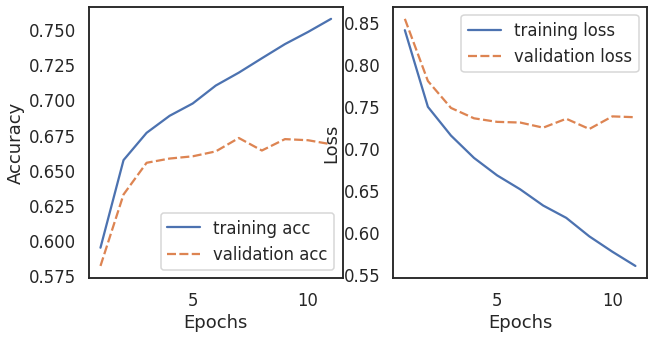

After training model_train, the accuracy is 0.6602243546425193
----------------------------------------------------------------------
Start to train model use the data : oversampling
----------------------------------------------------------------------

 before training model, the accuracy is 0.3479212253829322
[epoch 1] train_loss: 0.787, train_acc:0.652, val_loss: 0.826, val_acc:0.608
[epoch 2] train_loss: 0.713, train_acc:0.690, val_loss: 0.799, val_acc:0.620
[epoch 3] train_loss: 0.672, train_acc:0.709, val_loss: 0.772, val_acc:0.641
[epoch 4] train_loss: 0.633, train_acc:0.728, val_loss: 0.758, val_acc:0.653
[epoch 5] train_loss: 0.601, train_acc:0.746, val_loss: 0.767, val_acc:0.650
[epoch 6] train_loss: 0.571, train_acc:0.760, val_loss: 0.772, val_acc:0.650
[epoch 7] train_loss: 0.543, train_acc:0.773, val_loss: 0.777, val_acc:0.654


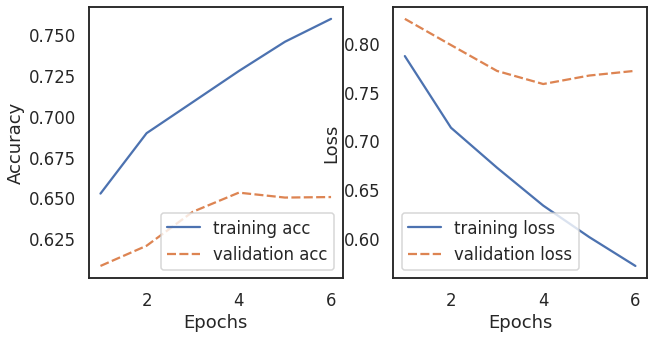

After training model_oversampling, the accuracy is 0.6463035545343966
----------------------------------------------------------------------
Start to train model use the data : 2_rep_(unfine)
----------------------------------------------------------------------

 before training model, the accuracy is 0.29428058254528144
[epoch 1] train_loss: 0.789, train_acc:0.643, val_loss: 0.875, val_acc:0.586
[epoch 2] train_loss: 0.707, train_acc:0.684, val_loss: 0.808, val_acc:0.621
[epoch 3] train_loss: 0.659, train_acc:0.708, val_loss: 0.792, val_acc:0.631
[epoch 4] train_loss: 0.625, train_acc:0.727, val_loss: 0.778, val_acc:0.641
[epoch 5] train_loss: 0.603, train_acc:0.735, val_loss: 0.761, val_acc:0.653
[epoch 6] train_loss: 0.569, train_acc:0.752, val_loss: 0.764, val_acc:0.652
[epoch 7] train_loss: 0.544, train_acc:0.765, val_loss: 0.765, val_acc:0.657
[epoch 8] train_loss: 0.521, train_acc:0.776, val_loss: 0.779, val_acc:0.652


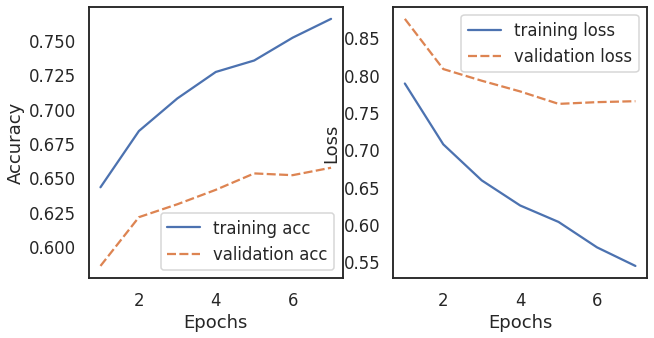

After training model_2_rep_(unfine), the accuracy is 0.6460332477361805
----------------------------------------------------------------------
Start to train model use the data : 3_rep_(unfine)
----------------------------------------------------------------------

 before training model, the accuracy is 0.345631992382766
[epoch 1] train_loss: 0.788, train_acc:0.640, val_loss: 0.883, val_acc:0.571
[epoch 2] train_loss: 0.700, train_acc:0.683, val_loss: 0.816, val_acc:0.619
[epoch 3] train_loss: 0.649, train_acc:0.710, val_loss: 0.777, val_acc:0.637
[epoch 4] train_loss: 0.615, train_acc:0.726, val_loss: 0.769, val_acc:0.642
[epoch 5] train_loss: 0.587, train_acc:0.739, val_loss: 0.769, val_acc:0.645
[epoch 6] train_loss: 0.560, train_acc:0.752, val_loss: 0.761, val_acc:0.647
[epoch 7] train_loss: 0.536, train_acc:0.764, val_loss: 0.775, val_acc:0.645
[epoch 8] train_loss: 0.514, train_acc:0.775, val_loss: 0.770, val_acc:0.653
[epoch 9] train_loss: 0.492, train_acc:0.787, val_loss: 0.77

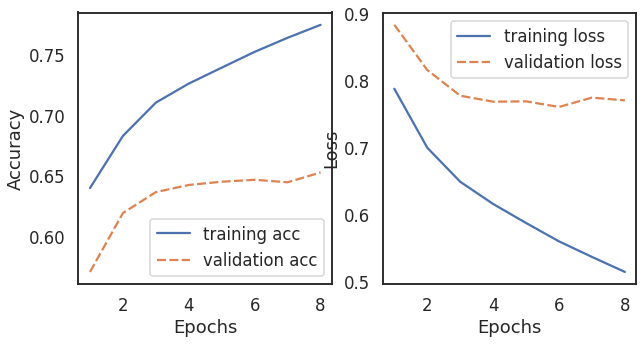

After training model_3_rep_(unfine), the accuracy is 0.6486011623192324
----------------------------------------------------------------------
Start to train model use the data : 4_rep_(unfine)
----------------------------------------------------------------------

 before training model, the accuracy is 0.31622341001060356
[epoch 1] train_loss: 0.765, train_acc:0.655, val_loss: 0.883, val_acc:0.581
[epoch 2] train_loss: 0.681, train_acc:0.696, val_loss: 0.815, val_acc:0.623
[epoch 3] train_loss: 0.638, train_acc:0.717, val_loss: 0.794, val_acc:0.629
[epoch 4] train_loss: 0.604, train_acc:0.732, val_loss: 0.774, val_acc:0.640
[epoch 5] train_loss: 0.578, train_acc:0.744, val_loss: 0.772, val_acc:0.649
[epoch 6] train_loss: 0.555, train_acc:0.755, val_loss: 0.764, val_acc:0.646
[epoch 7] train_loss: 0.533, train_acc:0.768, val_loss: 0.786, val_acc:0.646
[epoch 8] train_loss: 0.511, train_acc:0.778, val_loss: 0.774, val_acc:0.647
[epoch 9] train_loss: 0.490, train_acc:0.788, val_loss: 0.

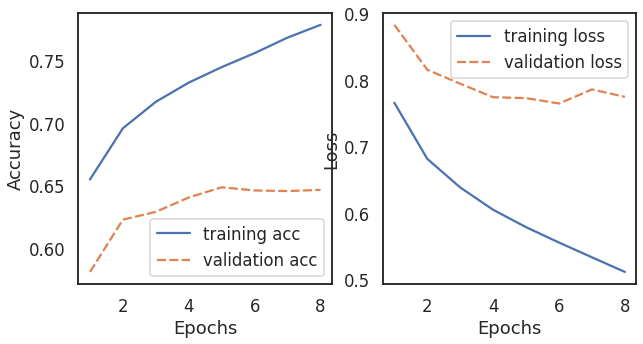

After training model_4_rep_(unfine), the accuracy is 0.6538721448844439
----------------------------------------------------------------------
Start to train model use the data : 5_rep_(unfine)
----------------------------------------------------------------------

 before training model, the accuracy is 0.3486832139533877
[epoch 1] train_loss: 0.772, train_acc:0.645, val_loss: 0.897, val_acc:0.571
[epoch 2] train_loss: 0.683, train_acc:0.691, val_loss: 0.818, val_acc:0.621
[epoch 3] train_loss: 0.635, train_acc:0.715, val_loss: 0.794, val_acc:0.634
[epoch 4] train_loss: 0.603, train_acc:0.731, val_loss: 0.773, val_acc:0.641
[epoch 5] train_loss: 0.575, train_acc:0.747, val_loss: 0.767, val_acc:0.644
[epoch 6] train_loss: 0.549, train_acc:0.758, val_loss: 0.775, val_acc:0.645
[epoch 7] train_loss: 0.526, train_acc:0.769, val_loss: 0.758, val_acc:0.651
[epoch 8] train_loss: 0.507, train_acc:0.779, val_loss: 0.763, val_acc:0.659
[epoch 9] train_loss: 0.490, train_acc:0.787, val_loss: 0.7

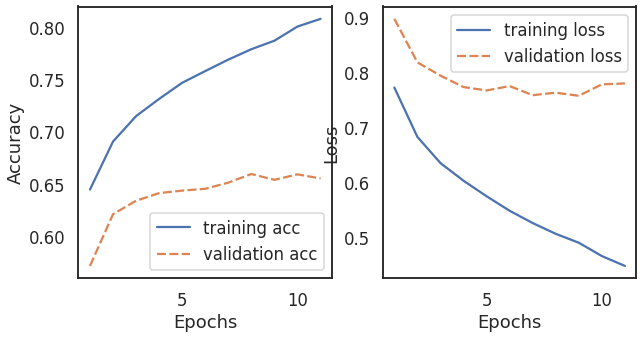

After training model_5_rep_(unfine), the accuracy is 0.6504933099067441
----------------------------------------------------------------------
Start to train model use the data : 6_rep_(unfine)
----------------------------------------------------------------------

 before training model, the accuracy is 0.34013546558178787
[epoch 1] train_loss: 0.800, train_acc:0.629, val_loss: 0.898, val_acc:0.558
[epoch 2] train_loss: 0.701, train_acc:0.684, val_loss: 0.809, val_acc:0.620
[epoch 3] train_loss: 0.644, train_acc:0.711, val_loss: 0.793, val_acc:0.632
[epoch 4] train_loss: 0.609, train_acc:0.726, val_loss: 0.780, val_acc:0.644
[epoch 5] train_loss: 0.581, train_acc:0.742, val_loss: 0.770, val_acc:0.647
[epoch 6] train_loss: 0.551, train_acc:0.757, val_loss: 0.774, val_acc:0.648
[epoch 7] train_loss: 0.528, train_acc:0.770, val_loss: 0.771, val_acc:0.649
[epoch 8] train_loss: 0.512, train_acc:0.776, val_loss: 0.776, val_acc:0.656


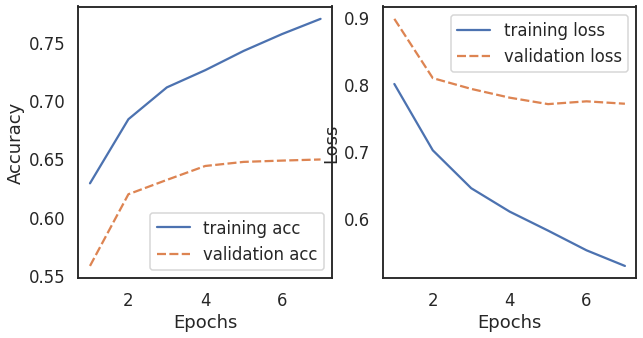

After training model_6_rep_(unfine), the accuracy is 0.6494120827138803
acc_list [0.6602243546425193, 0.6463035545343966, 0.6460332477361805, 0.6486011623192324, 0.6538721448844439, 0.6504933099067441, 0.6494120827138803]
loss_list [0.7537126114656185, 0.7798982565772945, 0.7759026931277637, 0.7701169709707129, 0.7842682032235737, 0.7883439842483093, 0.7690699925196582]
precision_list [array([0.59287257, 0.63677511, 0.70966644]), array([0.49682338, 0.63644239, 0.76037257]), array([0.51023503, 0.62955801, 0.74308943]), array([0.52784314, 0.62981716, 0.73452705]), array([0.53327855, 0.63616257, 0.73606238]), array([0.53367434, 0.63176796, 0.72908672]), array([0.52485738, 0.62002069, 0.76496097])]
recall_list [array([0.47003425, 0.68212121, 0.71136131]), array([0.66952055, 0.66787879, 0.61276015]), array([0.57619863, 0.69060606, 0.62367793]), array([0.57619863, 0.67848485, 0.64380757]), array([0.55565068, 0.69727273, 0.64414875]), array([0.5359589 , 0.6930303 , 0.64824292]), array([0.5513

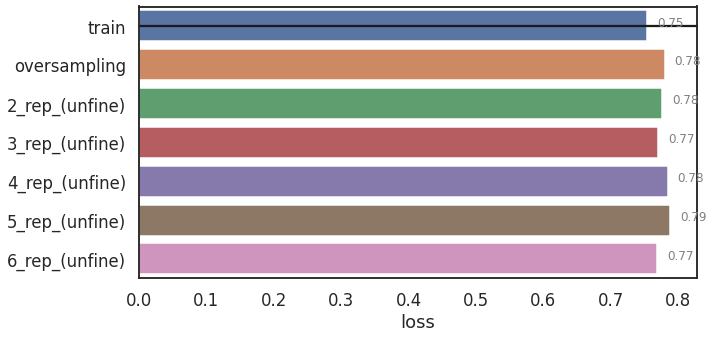

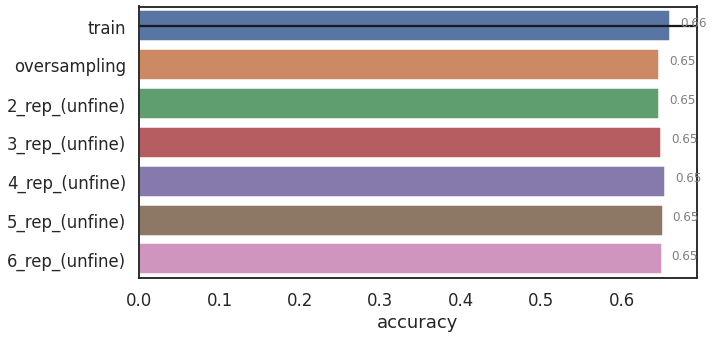

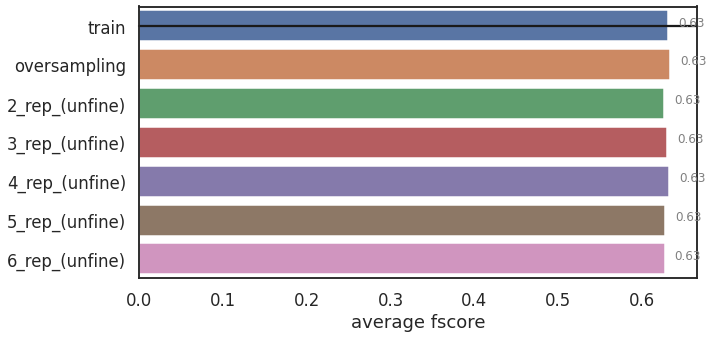

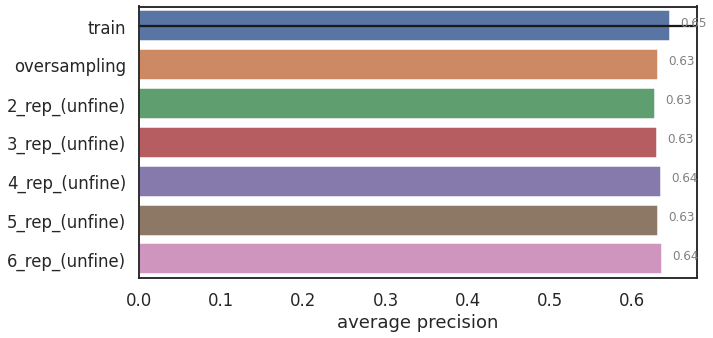

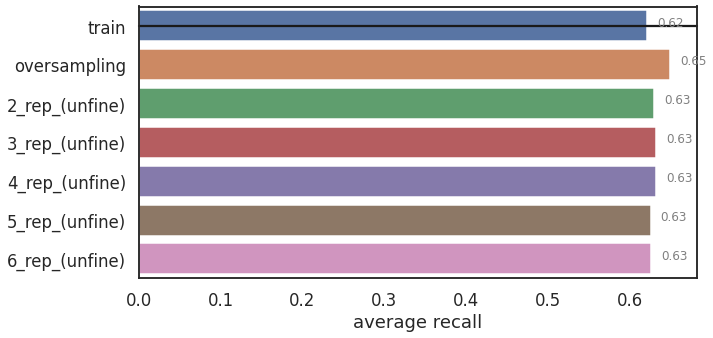

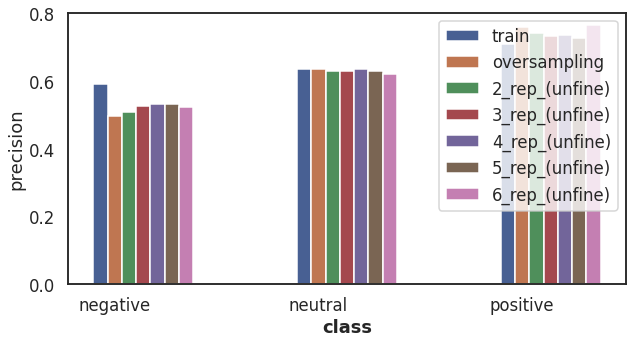

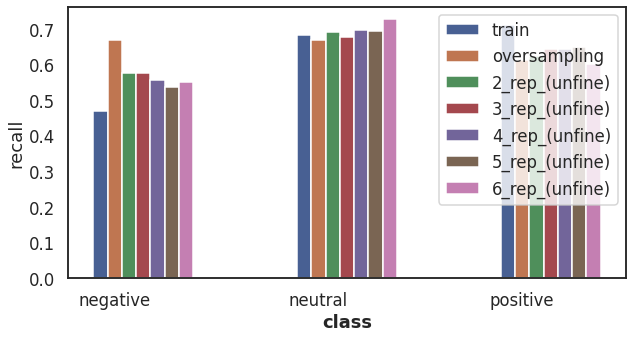

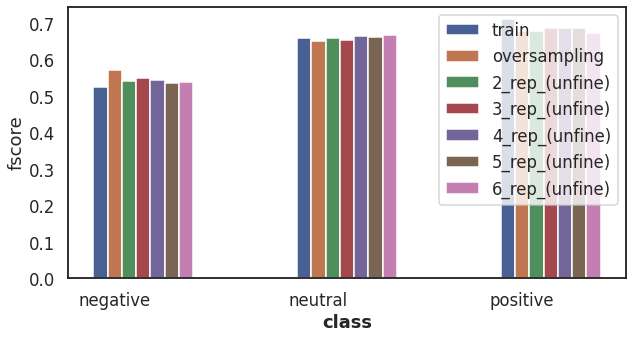

CPU times: user 2h 34min 24s, sys: 49min 12s, total: 3h 23min 37s
Wall time: 3h 23min 42s


In [39]:
%%time
test_list = [
              'train',
              'oversampling',
              '2_rep_(unfine)',
              '3_rep_(unfine)',
              '4_rep_(unfine)',
              '5_rep_(unfine)',
              '6_rep_(unfine)'
              ]
              
task_name = 'twitter'
tech_name = 'Bert_ data augmentation-master'

execute(test_list, tech_name, task_name)

### BERT Finetune 

----------------------------------------------------------------------
Start to train model use the data : train
----------------------------------------------------------------------

 before training model, the accuracy is 0.37996017835609525
[epoch 1] train_loss: 0.825, train_acc:0.608, val_loss: 0.836, val_acc:0.599
[epoch 2] train_loss: 0.744, train_acc:0.655, val_loss: 0.766, val_acc:0.644
[epoch 3] train_loss: 0.707, train_acc:0.677, val_loss: 0.749, val_acc:0.652
[epoch 4] train_loss: 0.685, train_acc:0.692, val_loss: 0.738, val_acc:0.663
[epoch 5] train_loss: 0.664, train_acc:0.703, val_loss: 0.727, val_acc:0.664
[epoch 6] train_loss: 0.646, train_acc:0.709, val_loss: 0.724, val_acc:0.671
[epoch 7] train_loss: 0.627, train_acc:0.723, val_loss: 0.728, val_acc:0.666
[epoch 8] train_loss: 0.607, train_acc:0.732, val_loss: 0.723, val_acc:0.676
[epoch 9] train_loss: 0.588, train_acc:0.743, val_loss: 0.729, val_acc:0.665
[epoch 10] train_loss: 0.571, train_acc:0.751, val_loss: 0.733

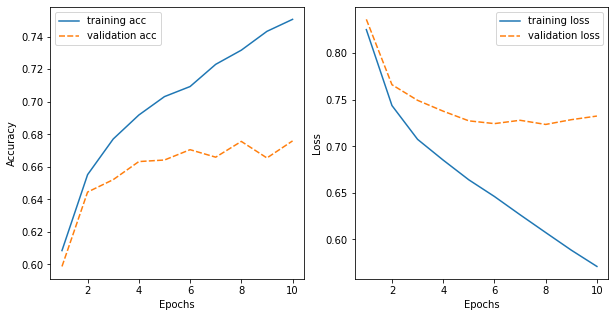

After training model_train, the accuracy is 0.6594134342478714
----------------------------------------------------------------------
Start to train model use the data : oversampling
----------------------------------------------------------------------

 before training model, the accuracy is 0.3545291071776762
[epoch 1] train_loss: 0.801, train_acc:0.640, val_loss: 0.854, val_acc:0.591
[epoch 2] train_loss: 0.721, train_acc:0.682, val_loss: 0.794, val_acc:0.626
[epoch 3] train_loss: 0.677, train_acc:0.707, val_loss: 0.791, val_acc:0.629
[epoch 4] train_loss: 0.640, train_acc:0.725, val_loss: 0.774, val_acc:0.641
[epoch 5] train_loss: 0.609, train_acc:0.741, val_loss: 0.757, val_acc:0.656
[epoch 6] train_loss: 0.577, train_acc:0.754, val_loss: 0.779, val_acc:0.647
[epoch 7] train_loss: 0.543, train_acc:0.773, val_loss: 0.771, val_acc:0.661
[epoch 8] train_loss: 0.517, train_acc:0.784, val_loss: 0.788, val_acc:0.653


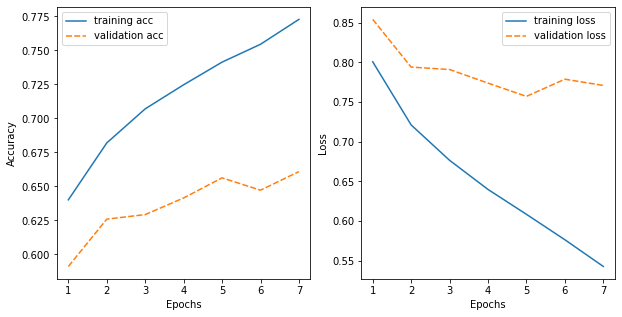

After training model_oversampling, the accuracy is 0.6445465603459927
----------------------------------------------------------------------
Start to train model use the data : 2_rep_(tuned)
----------------------------------------------------------------------


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



 before training model, the accuracy is 0.31827919759364653
[epoch 1] train_loss: 0.800, train_acc:0.640, val_loss: 0.875, val_acc:0.580
[epoch 2] train_loss: 0.724, train_acc:0.682, val_loss: 0.817, val_acc:0.619
[epoch 3] train_loss: 0.679, train_acc:0.703, val_loss: 0.792, val_acc:0.631
[epoch 4] train_loss: 0.646, train_acc:0.717, val_loss: 0.768, val_acc:0.648
[epoch 5] train_loss: 0.616, train_acc:0.734, val_loss: 0.772, val_acc:0.645
[epoch 6] train_loss: 0.590, train_acc:0.747, val_loss: 0.769, val_acc:0.649
[epoch 7] train_loss: 0.563, train_acc:0.760, val_loss: 0.774, val_acc:0.649


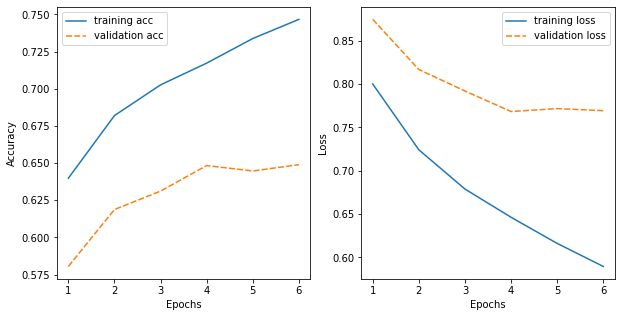

After training model_2_rep_(tuned), the accuracy is 0.6431950263549129
----------------------------------------------------------------------
Start to train model use the data : 3_rep_(tuned)
----------------------------------------------------------------------

 before training model, the accuracy is 0.3503711237584125
[epoch 1] train_loss: 0.809, train_acc:0.635, val_loss: 0.845, val_acc:0.596
[epoch 2] train_loss: 0.728, train_acc:0.677, val_loss: 0.802, val_acc:0.622
[epoch 3] train_loss: 0.685, train_acc:0.700, val_loss: 0.799, val_acc:0.627
[epoch 4] train_loss: 0.652, train_acc:0.717, val_loss: 0.771, val_acc:0.645
[epoch 5] train_loss: 0.621, train_acc:0.732, val_loss: 0.768, val_acc:0.652
[epoch 6] train_loss: 0.598, train_acc:0.743, val_loss: 0.770, val_acc:0.651
[epoch 7] train_loss: 0.572, train_acc:0.758, val_loss: 0.765, val_acc:0.656
[epoch 8] train_loss: 0.549, train_acc:0.768, val_loss: 0.766, val_acc:0.656
[epoch 9] train_loss: 0.530, train_acc:0.779, val_loss: 0.775

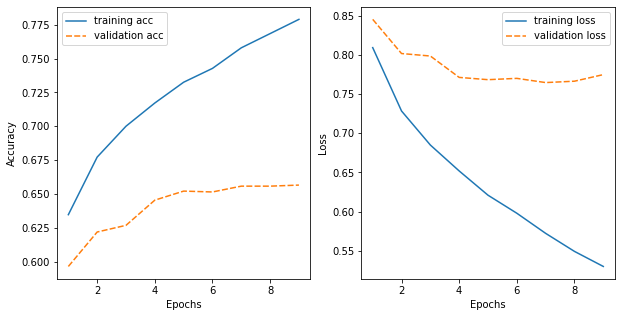

After training model_3_rep_(tuned), the accuracy is 0.6515745370996081
----------------------------------------------------------------------
Start to train model use the data : 4_rep_(tuned)
----------------------------------------------------------------------

 before training model, the accuracy is 0.3480772976131224
[epoch 1] train_loss: 0.833, train_acc:0.621, val_loss: 0.866, val_acc:0.585
[epoch 2] train_loss: 0.743, train_acc:0.671, val_loss: 0.812, val_acc:0.614
[epoch 3] train_loss: 0.695, train_acc:0.694, val_loss: 0.799, val_acc:0.628
[epoch 4] train_loss: 0.664, train_acc:0.710, val_loss: 0.782, val_acc:0.641
[epoch 5] train_loss: 0.636, train_acc:0.726, val_loss: 0.778, val_acc:0.644
[epoch 6] train_loss: 0.606, train_acc:0.739, val_loss: 0.780, val_acc:0.647
[epoch 7] train_loss: 0.584, train_acc:0.752, val_loss: 0.783, val_acc:0.642
[epoch 8] train_loss: 0.558, train_acc:0.763, val_loss: 0.792, val_acc:0.648


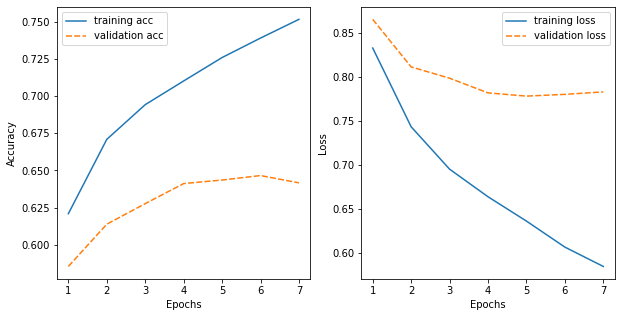

After training model_4_rep_(tuned), the accuracy is 0.6387349641843493
----------------------------------------------------------------------
Start to train model use the data : 5_rep_(tuned)
----------------------------------------------------------------------

 before training model, the accuracy is 0.30949341065979963
[epoch 1] train_loss: 0.817, train_acc:0.632, val_loss: 0.879, val_acc:0.580
[epoch 2] train_loss: 0.740, train_acc:0.673, val_loss: 0.827, val_acc:0.615
[epoch 3] train_loss: 0.695, train_acc:0.695, val_loss: 0.791, val_acc:0.637
[epoch 4] train_loss: 0.657, train_acc:0.715, val_loss: 0.797, val_acc:0.636
[epoch 5] train_loss: 0.622, train_acc:0.735, val_loss: 0.777, val_acc:0.644
[epoch 6] train_loss: 0.600, train_acc:0.743, val_loss: 0.764, val_acc:0.659
[epoch 7] train_loss: 0.571, train_acc:0.757, val_loss: 0.788, val_acc:0.650
[epoch 8] train_loss: 0.546, train_acc:0.769, val_loss: 0.784, val_acc:0.649
[epoch 9] train_loss: 0.520, train_acc:0.780, val_loss: 0.79

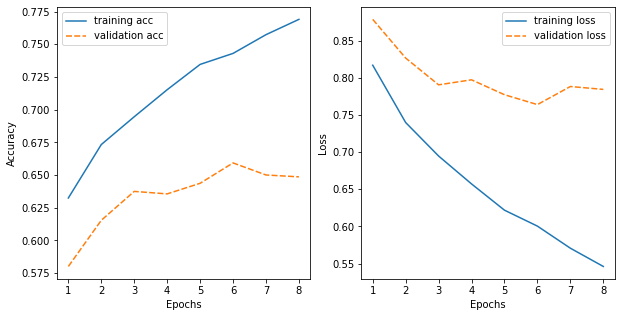

After training model_5_rep_(tuned), the accuracy is 0.6454926341397487
----------------------------------------------------------------------
Start to train model use the data : 6_rep_(tuned)
----------------------------------------------------------------------

 before training model, the accuracy is 0.3347038583886953
[epoch 1] train_loss: 0.834, train_acc:0.620, val_loss: 0.886, val_acc:0.573
[epoch 2] train_loss: 0.749, train_acc:0.667, val_loss: 0.828, val_acc:0.604
[epoch 3] train_loss: 0.703, train_acc:0.690, val_loss: 0.799, val_acc:0.628
[epoch 4] train_loss: 0.665, train_acc:0.709, val_loss: 0.796, val_acc:0.633
[epoch 5] train_loss: 0.638, train_acc:0.721, val_loss: 0.794, val_acc:0.639
[epoch 6] train_loss: 0.604, train_acc:0.739, val_loss: 0.783, val_acc:0.640
[epoch 7] train_loss: 0.576, train_acc:0.754, val_loss: 0.778, val_acc:0.654
[epoch 8] train_loss: 0.549, train_acc:0.767, val_loss: 0.789, val_acc:0.649
[epoch 9] train_loss: 0.522, train_acc:0.780, val_loss: 0.795

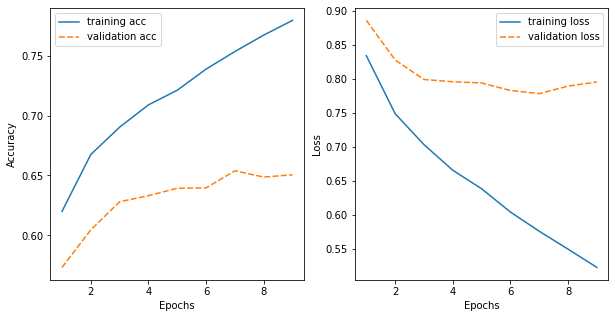

After training model_6_rep_(tuned), the accuracy is 0.641438032166509
acc_list [0.6594134342478714, 0.6445465603459927, 0.6431950263549129, 0.6515745370996081, 0.6387349641843493, 0.6454926341397487, 0.641438032166509]
loss_list [0.757332859881993, 0.8002251545930731, 0.7842333378462956, 0.794417580140048, 0.8061737983391203, 0.7927427258470963, 0.82191391751684]
precision_list [array([0.63215591, 0.63419973, 0.69859733]), array([0.48471616, 0.6414928 , 0.75595487]), array([0.48792884, 0.63850456, 0.75041186]), array([0.50872093, 0.64567156, 0.73684211]), array([0.46962617, 0.64367127, 0.75478113]), array([0.5003712 , 0.63433668, 0.74107143]), array([0.47973856, 0.63486655, 0.75671069])]
recall_list [array([0.44434932, 0.70242424, 0.69669055]), array([0.66523973, 0.66151515, 0.6171955 ]), array([0.65753425, 0.65727273, 0.62163084]), array([0.59931507, 0.68030303, 0.64005459]), array([0.68835616, 0.65030303, 0.60593654]), array([0.57705479, 0.68969697, 0.62299556]), array([0.62842466, 0

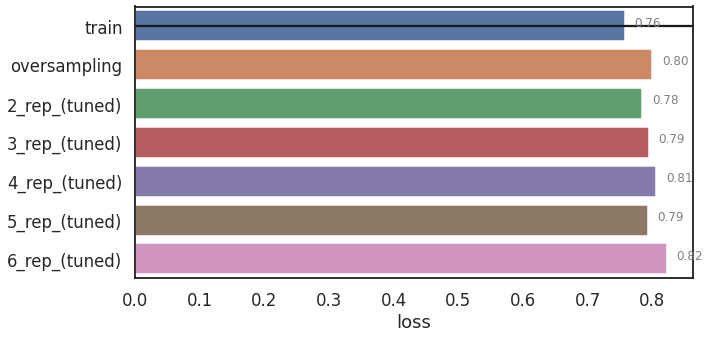

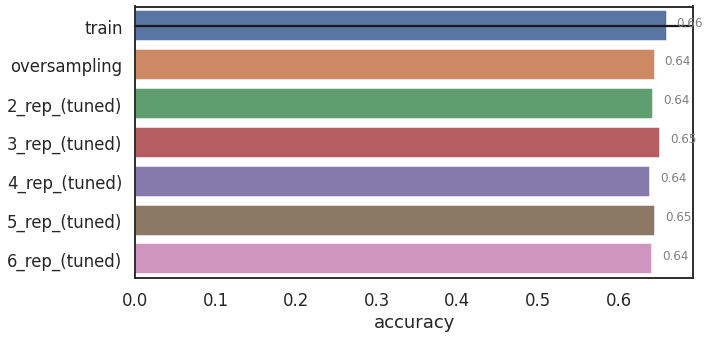

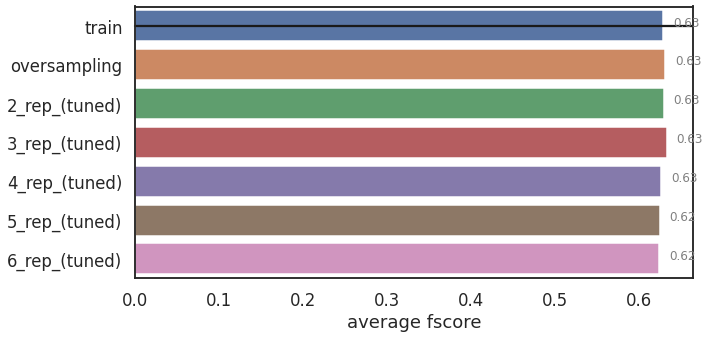

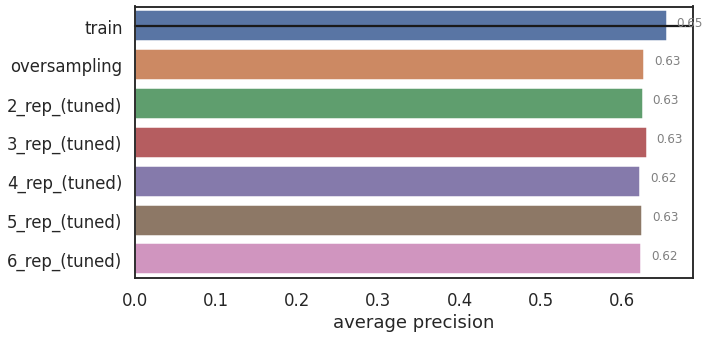

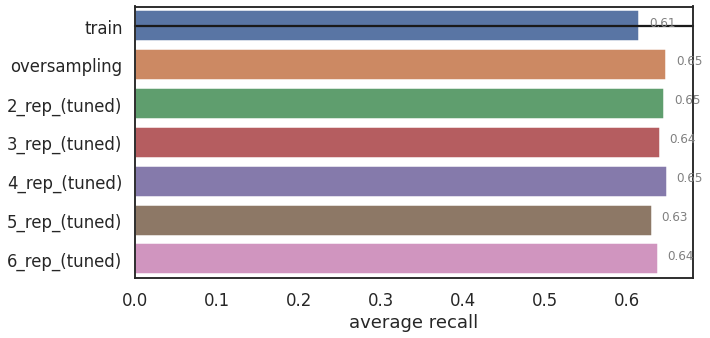

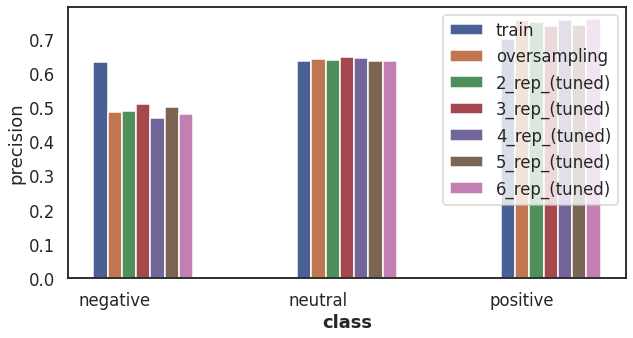

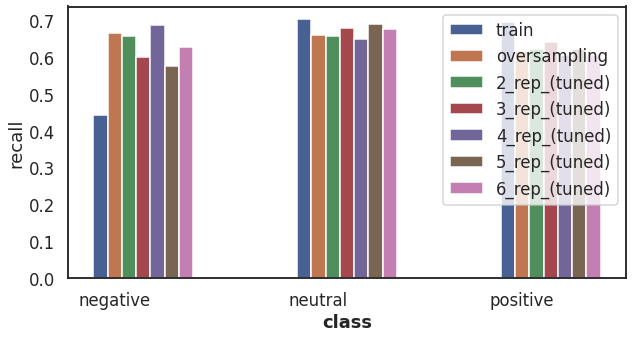

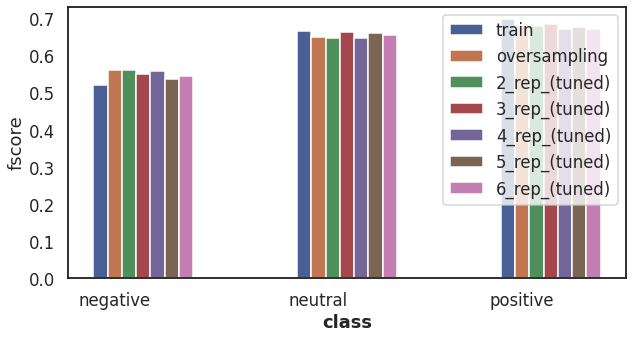

CPU times: user 2h 30min 32s, sys: 47min 36s, total: 3h 18min 9s
Wall time: 3h 18min 15s


In [28]:
%%time
test_list = [
              'train',
              'oversampling',
              '2_rep_(tuned)',
              '3_rep_(tuned)',
              '4_rep_(tuned)',
              '5_rep_(tuned)',
              '6_rep_(tuned)'
              ]
              
task_name = 'twitter'
tech_name = 'Bert_ data augmentation-master'

execute(test_list, tech_name, task_name)

## full data result